In [1]:
import mysql.connector
import warnings
import requests
import json
import codecs
from bs4 import BeautifulSoup
import time
import os, sys
import re
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
# Function to Create a table in SQL 
def create_sql_table(SQL_DB, SQL_TABLE, SQL_TABLE_DEF):
    try:
        #connect to server
        conn = mysql.connector.connect(host='localhost',
                                            user='root',
                                            password='')
        cursor = conn.cursor()

        query = "CREATE DATABASE IF NOT EXISTS " + SQL_DB
        #print(query)
        cursor.execute(query);
        
        query = "CREATE TABLE IF NOT EXISTS " + SQL_DB + "." + SQL_TABLE + " " + SQL_TABLE_DEF + ";";
        #print(query)
        cursor.execute(query);
        cursor.close()
        conn.close()
        return

    except IOError as e:
        print(e)

In [3]:
# Storing the Amazon URLs to "goldboxdeals_asin.txt"
try:
    # Storing the value of headers for accessing the ebay URLs
    headers={'User-Agent': 'Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36',
                   'Accept-Language': 'en-US, en;q=0.5'}
    # Saving Similar Product URL using inputed URLs
    with open('goldboxdeals_asin.txt', 'w+') as outfile:
        # Accessing the search results pagewise
        URL = input("Enter a Product URL of Choice: ")
        #print(URL)
        page = requests.get(URL, headers=headers)
        doc = BeautifulSoup(page.content, "html.parser")
        #print(doc)
                
        # Extract all the ProductIDs whose information is listed on the Page
        asinTag = []
        asinMatch = [x.group() for x in re.finditer('"(B0[a-zA-Z0-9_]{8})"', str(doc))]
        if asinMatch:
            for tags in asinMatch:
                tags = tags[1:-1]
                if tags not in asinTag:
                    asinTag.append(tags)
                
            position = 0 
            # Extract ProductIDs for approximately 1000 similar products
            while len(asinTag) < 1000:
                #Pause between requests
                position = position + 1
                URL = "https://www.amazon.com/dp/" + str(asinTag[position])
                time.sleep(4)
                page = requests.get(URL, headers=headers)
                doc = BeautifulSoup(page.content, "html.parser")
                #print(doc)
                
                asinMatch = [x.group() for x in re.finditer('"(B0[a-zA-Z0-9_]{8})"', str(doc))]
                for tags in asinMatch:
                    tags = tags[1:-1]
                    if tags not in asinTag:
                        asinTag.append(tags)
                #print(len(asinTag))
                if position == len(asinTag):
                    break
        else:
            print("No Products Found")
            
        # Create and store the corresponding URL in the file
        for j in asinTag:
            links = "https://www.amazon.com/dp/" + j
            outfile.write(links + '\n')
                
    # Displaying the downloaded summary
    print("\nStatus: goldboxdeals_asin.txt succesfully created")
    print("\nTotal Number of Product for Analysis: " + str(len(asinTag)))
        
except Exception as ex:
    print("Error:" + str(ex))

Enter a Product URL of Choice: https://www.amazon.com/Potency-Tablets-Immune-System-Support/dp/B01FCFOIN2/ref=gbps_tit_s-5_cd34_54942690?smid=A2VAPKJ4A47X54&pf_rd_p=fd51d8cf-b5df-4144-8086-80096db8cd34&pf_rd_s=slot-5&pf_rd_t=701&pf_rd_i=gb_main&pf_rd_m=ATVPDKIKX0DER&pf_rd_r=WS2SMVNTXTT2SKMSXS9S&spLa=ZW5jcnlwdGVkUXVhbGlmaWVyPUEzSkZIVUlISlVKUENKJmVuY3J5cHRlZElkPUEwNjA5MDEySjNINjNZUUlHOEhBJmVuY3J5cHRlZEFkSWQ9QTA3MjUzODAxUU8xUTFMSEpFSklaJndpZGdldE5hbWU9c3BfZ2JfbWFpbl9zdXBwbGUmYWN0aW9uPWNsaWNrUmVkaXJlY3QmZG9Ob3RMb2dDbGljaz10cnVl

Status: goldboxdeals_asin.txt succesfully created

Total Number of Product for Analysis: 1004


In [14]:
# Creating the target table amazondeals in SQL DB
try:
    # Storing the details of table and query to create the table
    SQL_DB = "msba"
    SQL_TABLE_DEALS = "amazonproducts"
    SQL_TABLE_DEALS_DEF = "(" + \
        "productAsin VARCHAR(10)," + \
        "URL VARCHAR(40)," + \
        "productTitle VARCHAR(300)," + \
        "productPrice DECIMAL(8,2)," + \
        "productListPrice DECIMAL(8,2)," + \
        "sellerName VARCHAR(200)," + \
        "manufacturerName VARCHAR(200)," + \
        "productRank BIGINT(10)," + \
        "CustomerRatings DECIMAL(2,1)," + \
        "TotalRatings BIGINT(10)," + \
        "ReviewCount BIGINT(10)," + \
        "ansQsCount BIGINT(10)," + \
        "availabilityCount VARCHAR(500)," + \
        "productFeatures varchar(3000)," + \
        "categoryName VARCHAR(40)," + \
        "subCategoryName VARCHAR(40)" + \
        ")"
        
    # Call to create an empty table named “amazondeals”
    create_sql_table(SQL_DB, SQL_TABLE_DEALS, SQL_TABLE_DEALS_DEF)
    print("Status: SQL table amazondeals succesfully created")
        
except Exception as ex:
    print("Error:" + str(ex))

Status: SQL table amazondeals succesfully created


In [15]:
# Navigating through the pages to extract product details
def main():  
    
    try:
        # Connect to server
        conn = mysql.connector.connect(host='localhost',
                                            database='msba',
                                            user='root',
                                            password='')
        cursor = conn.cursor()
        SQL_TABLE_DEALS = 'amazondeals'
        
        # Time delays
        delays = [7, 4, 6, 2, 10, 19]
        
        # Storing the value of headers for accessing the URLs
        headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
                   'referrer': 'https://google.co.in',
                   'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
                   'Accept-Encoding': 'gzip, deflate, br',
                   'Accept-Language': 'en-US,en;q=0.9',
                   'Pragma': 'no-cache'
                  }
        # Accessing the amazonproducts.txt file 
        filename = "goldboxdeals_asin.txt"
        with open(filename, 'r') as file:
            # Navigating through the lines in amazonproducts
            line = file.readline()
            while line: 
                URL = line.strip()
                page = requests.get(URL, headers=headers)
                doc = BeautifulSoup(page.content, 'html.parser') 
                #print(doc)
                
                # Extracting the "asin" for the corresponsing URL
                urlAsin = re.search(r'/dp/([^/]+)', URL, flags=re.IGNORECASE)
                productAsin = urlAsin.group(1) 
                print("Product ID: " + productAsin)
                
                # Selector command for "Title"
                titletag = doc("span", {"id": "productTitle"})
                if titletag:
                    productTitle = (titletag[0].text).strip()
                else:
                    productTitle = None
                    print("\n")
                    line = file.readline()
                    # Pause between page requests
                    delay = np.random.choice(delays)
                    time.sleep(delay)
                    continue
                print("Title: " + str(productTitle))
                
                # Selector command for "Category" & "Sub-category"
                categorytag = doc.select("div.a-subheader.a-breadcrumb.feature > ul > li")
                if categorytag:
                    categoryName = (categorytag[0].text).strip()
                    subCategoryName = (categorytag[2].text).strip()
                    print("Product Category: " + categoryName)
                    print("Product Sub-Category: " + subCategoryName)
                else:
                    categoryName = None
                    subCategoryName = None
                
                # Selector commands for "Item Price"
                itemPricetag1 = doc("span", {"id": "priceblock_dealprice"})
                itemPricetag2 = doc("span", {"id": "priceblock_ourprice"})
                itemPricetag3 = doc("span", {"id": "priceblock_saleprice"})
                itemPricetag4 = doc("span", {"id": "priceblock_pospromoprice"})
                if itemPricetag1:
                    itemPricetag_text = re.findall("\$([0-9]+.[0-9]+)", itemPricetag1[0].text)
                    productPrice = itemPricetag_text[0]
                    productPrice = float(productPrice)
                elif itemPricetag2:
                    itemPricetag_text = re.findall("\$([0-9]+.[0-9]+)", itemPricetag2[0].text)
                    productPrice = itemPricetag_text[0]
                    productPrice = float(productPrice)
                elif itemPricetag3:
                    itemPricetag_text = re.findall("\$([0-9]+.[0-9]+)", itemPricetag3[0].text)
                    productPrice = itemPricetag_text[0]
                    productPrice = float(productPrice)
                elif itemPricetag4:
                    itemPricetag_text = re.findall("\$([0-9]+.[0-9]+)", itemPricetag4[0].text)
                    productPrice = itemPricetag_text[0]
                    productPrice = float(productPrice)
                else:
                    productPrice = None
                    print("\n")
                    line = file.readline()
                    # Pause between page requests
                    delay = np.random.choice(delays)
                    time.sleep(delay)
                    continue
                print("Price: " + str(productPrice))
                    
                # Selector commands for "List Price"
                ListPricetag1 = doc("span",{"class": "priceBlockStrikePriceString a-text-strike"})
                if ListPricetag1:
                    ListPricetag_text = re.findall("\$([0-9]+.[0-9]+)", ListPricetag1[0].text)
                    productListPrice = ListPricetag_text[0]
                    productListPrice = float(productListPrice)
                else:
                    productListPrice = None
                print("List Price: " + str(productListPrice))
                
                # Selector commands for "Seller Name"
                sellerTag = doc("a",{"id": "sellerProfileTriggerId"})
                if sellerTag:
                    sellerName = (sellerTag[0].text).strip()
                else: 
                    sellerName = None
                print("Seller Name: " + str(sellerName))
                
                # Selector commands for Feature List
                featurestag = doc.find("div", {"id": "feature-bullets"})
                if featurestag:
                    feature_list = featurestag.find_all('li')
                    productFeatures = ' || '.join([(item.text).strip() for item in feature_list])
                else:
                    productFeatures = None
                print("Feature List: " + str(productFeatures))
                
                # Selector command for "Manufacturer Name", "Product Ratings", "Product Ranking"
                manufacturerName = None
                productRank = None
                CustomerRatings = None
                producttag = doc.find("div", {"id": "detailBullets_feature_div"})
                if producttag:
                    list_items = producttag.find_all('li')
                    if list_items: 
                        for index, obj in enumerate(list_items):
                            matchText = (obj.text).strip()
                            # Selector for Manufacturer Name
                            if (re.match("Manufacturer", matchText)):
                                manufacturerName = ((list_items[index]).text).strip()
                                manufacturerName = (manufacturerName.split(':')[1]).strip()
                            # Selector for Product Ranking
                            if (re.search("(.*)(Best Sellers Rank)(.*)", matchText, re.IGNORECASE)):
                                productRank = ((list_items[index]).text).strip()
                                productRank_text = re.findall("\#([^\s]*)", productRank)
                                productRank = (productRank_text[0]).replace(",", "")
                    else:
                        manufacturerName = None
                        productRank = None
                else:
                    manufacturerName = None
                    productRank = None
                print("Manufacturer Name: " + str(manufacturerName))

                # Selector for Product Ranking
                if productRank is None:
                    productRank = doc("li",{"id": "SalesRank"})
                    if productRank:
                        productRank_text = re.findall("\#([^\s]*)", productRank[0].text)
                        if productRank_text:
                            productRank = ((productRank_text[0]).replace(",", "")).strip()
                        else:
                            productRank = None 
                    else:
                        productRank = None
                        print("Product Rank: " + str(productRank))
                else:
                    print("Product Rank: " + str(productRank))
                
                # Selector for Product Start Ratings
                starRatingsTag = doc.find("div",{"id": "averageCustomerReviews"})
                if starRatingsTag:
                    starRatings = starRatingsTag.find('span',class_='a-icon-alt')
                    starRatings_text = re.findall("(\S+)(\s+)(out)", starRatings.text)
                    CustomerRatings = ((starRatings_text[0][0]).replace(",", ""))
                else:
                    CustomerRatings = None
                print("Customer Star Ratings: " + str(CustomerRatings))
                
                # Selector for Total Customer Ratings
                totalRatingsTag = doc("span",{"id": "acrCustomerReviewText"})
                if totalRatingsTag:
                    TotalRatings_text = re.findall("(\S+)(\s+)(rating)", totalRatingsTag[0].text)
                    TotalRatings = ((TotalRatings_text[0][0]).replace(",", "")).strip()
                else:
                    TotalRatings = None
                print("Total Ratings: " + str(TotalRatings))
                
                # Selector commands for "Number of Reviews"
                reviewURL = "https://www.amazon.com/product-reviews/" + productAsin
                pageReview = requests.get(reviewURL, headers=headers)
                docReview = BeautifulSoup(pageReview.content, 'html.parser')
                ReviewCounttag = docReview("div",{"data-hook": "cr-filter-info-section"})
                if ReviewCounttag:
                    ReviewCount = re.findall("(\|)\s(\S+)", ReviewCounttag[0].text)
                    ReviewCount = (ReviewCount[0][1]).replace(",", "")
                else:
                    ReviewCount = None
                print("Number of Reviews: " + str(ReviewCount))
                
                # Selector commands for "Number of Answered Questions"
                ansQstag = doc("a",{"id": "askATFLink"})
                if ansQstag:
                    ansQsCount = re.findall("([0-9]+)", ansQstag[0].text)
                    ansQsCount = ansQsCount[0]
                else:
                    ansQsCount = None
                print("Answered Questions: " + str(ansQsCount))
               
                # Selector commands for "Availability"
                availabilitytag = doc("div",{"id": "availability"})
                if availabilitytag:
                    availabilityCount = (availabilitytag[0].text).strip()
                else:
                    availabilityCount = None
                print("Availability: " + str(availabilityCount))
                
                # Statements to insert the record to the database
                parameterized_stmt = "INSERT INTO " + SQL_TABLE_DEALS + \
                " (productAsin, URL, productTitle, productPrice, productListPrice, sellerName, manufacturerName, \
                productRank, CustomerRatings, TotalRatings, ReviewCount, ansQsCount, availabilityCount, \
                productFeatures, categoryName, subCategoryName) \
                values (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);"
                cursor.execute(parameterized_stmt, (productAsin, URL, productTitle, productPrice, productListPrice, sellerName, manufacturerName, productRank, CustomerRatings, TotalRatings, ReviewCount, ansQsCount, availabilityCount, productFeatures, categoryName, subCategoryName,))
                #count_inserts = count_inserts +1
                conn.commit()
                
                print("\n")
                line = file.readline()
                # Pause between page requests
                delay = np.random.choice(delays)
                time.sleep(delay)
            # Pause between page requests
            time.sleep(delay)
        
        # Closing the connections to the database
        cursor.close()
        conn.close()
        print("All Row(s) successfully inserted")

    except Exception as ex:
        print("Error:" + str(ex))

if __name__ == "__main__":
    main()

Product ID: B01FCFOIN2
Title: Zinc 50mg [High Potency] Supplement - Immune Support System from Natural Zinc (Oxide/Citrate) 100 Tablets, Made by Nature’s Potent.
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 17.95
List Price: 19.95
Seller Name: Nature's Potent
Feature List: Immune Support Team - Zinc has immune-enhancing properties and is also vital for normal growth and development.* Zinc Supplements also plays a role in antioxidant support.* || Zinc for Women – Zinc is a key nutrient during pregnancy, essential for proper growth and development in a fetus. Also can be combined with multivitamin for women. || Zinc for Men – Zinc Supplement has been shown good benefits for men. Our body uses zinc to make proteins. This means zinc plays a key role in building and maintaining lean muscle mass. || Premium Quality - Zinc tablets made to Nature’s Potent guaranteed purity potency standards. Zinc can be used with other Best Multivitamins like

Number of Reviews: 5
Answered Questions: 3
Availability: In Stock.


Product ID: B0012ZQPKG
Title: Thorne Research - Zinc Picolinate 30 mg - Well-Absorbed Zinc Supplement for Growth and Immune Function - 60 Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 16.0
List Price: None
Seller Name: iServe
Feature List: 30 mg of zinc per capsule || Form of zinc used in numerous clinical studies || Essential for growth and immune function || Promotes reproductive health || Free From: Every Thorne product is made with the purest possible ingredients - without gluten or other major allergens (eggs, tree nuts, peanuts). This product also contains no soy, dairy, yeast, shellfish, or fish.
Manufacturer Name: Thorne Research
Product Rank: 3010
Customer Star Ratings: 4.8
Total Ratings: 2620
Number of Reviews: 163
Answered Questions: 30
Availability: In Stock.


Product ID: B0872LNJW4
Title: Zinc 30 mg -Zinc Methionine Highly Absorbable BioAvailabl

Number of Reviews: 33
Answered Questions: None
Availability: In Stock.


Product ID: B08PHSCVJY
Title: Zinc Gummies - 2 Pack - High Potency Immune Booster Zinc Supplement, Immune Defense, Powerful Natural Antioxidant, Non-GMO Zinc 50mg - by New Age, 120 Count
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 24.95
List Price: None
Seller Name: NewAgeWholesale
Feature List: Support Healthy Immune System - New Age Zinc gummies are a great way to boost your immune system for the season. Zinc supplements are powerful antioxidants that support a strong immune response, wound healing, cell production and many other vital functions || Healthy Sleep - New Age Zinc Gummies may help promote longer deep sleep cycles throughout the night. As a result, this mineral vitamin helps to support your cognitive ability, mood, and energy levels. New Age Zinc Gummies absorb faster into the bloodstream giving you the most effective daily dosage || Purity Tested 

Number of Reviews: 351
Answered Questions: 38
Availability: In Stock.


Product ID: B0875JZ9LP
Title: High Potency Zinc Picolinate 50MG- Pharmaceutical Grade Vegan Zinc Supplement for Immune Support, Free Radical Protection, Energy Boost & Skin Health Support- 60 Capsules- 2 Month Supply
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 12.99
List Price: None
Seller Name: Smart Nutra Labs
Feature List: Smart nutra labs 100% pure pharmaceutical grade high potency zinc provides 50mg of high quality zinc picolinate per capsule, each pack containing 60 vegan capsules, 2 month supply || High absorption zinc for immune boost; powerful antioxidant that promotes stronger immune system & healthy cell function || Supports healthy connective tissue, skin, eye, hair growth, reduction in oxidative stress and better quality sleep || Premium quality all natural ingredients; easy to swallow vegan capsules || 100% satisfaction money back guarantee, made in

Number of Reviews: 31
Answered Questions: None
Availability: In Stock.


Product ID: B07JM4HZPV
Title: Frunutta Zinc + Vitamin C Supplement, Supports Immune System – Pure, Sugar-Free, Non-GMO, Vegetarian – Instant Dissolve Tablets for Children and Adults, 90 Tablets, Proudly Made in The USA
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 14.99
List Price: None
Seller Name: FRUNUTTA
Feature List: Zinc and Vitamin C Your Body Can Actually Absorb, And Quickly: Unlike pills, where the active ingredients must pass through the intestinal tract, Frunutta Zinc 5 mg + Vitamin C 15 mg Micro Quick Absorb tablets dissolve under the tongue to directly diffuse into the bloodstream providing faster, more complete absorption. Zinc together with Vitamin C are known to support a healthy immune system, eye health, and may help wounds heal faster. Each bottle contains 90 tablets. || No More Swallowing Pills: Frunutta produces small, pure tablets that dissol

Number of Reviews: 80
Answered Questions: 4
Availability: In Stock.


Product ID: B0872LTFP9
Title: Zinc 50mg Supplement 120 Vegetarian Capsules, Zinc Highly Absorbable Supplements for Immune Support System, Gluten Free Zinc Supplement
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 12.95
List Price: None
Seller Name: Sandhu Herbals
Feature List: Zinc supplements for immune health support. zinc 50mg per serving || Zinc mono methionine is superior absorption and retention than other forms of zinc supplements || Zinc mono methionine promotes reproductive health. Always take with food || Taking zinc supplements everyday may support cognitive ability, mood, energy levels and promote a more restful sleep. the antioxidant effects of zinc also help improve the elasticity of your skin || Zinc gluten free and soy free
Manufacturer Name: Sunbotanicals
Product Rank: 1053
Customer Star Ratings: 4.7
Total Ratings: 12387
Number of Reviews: 239
Answere

Number of Reviews: 11137
Answered Questions: 433
Availability: In Stock.


Product ID: B01J2ZA8HI
Title: NatureWise Vitamin D3 2000iu (50 mcg) 1 Year Supply for Healthy Muscle Function, Bone Health, and Immune Support, Non-GMO, Gluten Free in Cold-Pressed Olive Oil, Packaging May Vary (360 Mini Softgels)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 14.49
List Price: None
Seller Name: Healthy Choice Nutrition
Feature List: GET YOUR ESSENTIAL DAILY DOSE: The Endocrine Society recommends 1,000-2,000IU of Vitamin D per day to maintain healthy bones, teeth, muscles and immune function. || MOST ACTIVE FORM: NatureWise Vitamin D3 delivers the same biologically active form of Vitamin D that is naturally produced in the body from sunlight — without the risky UVB exposure. || SUPERIOR ABSORPTION: Vitamin D is a fat-soluble vitamin that requires dietary fat for the body to absorb it. Our Vitamin D3 is delivered in certified organic olive oil, a 

Number of Reviews: 1960
Answered Questions: 51
Availability: In Stock.


Product ID: B07H8RC4BZ
Title: Vegan Vitamin D3 5000iu (125mcg) with Coconut Oil | 100% Plant-Based Supplement for Bone, Joint & Immune Support | Vegan Certified & Non-GMO Verified (60 PlantGels)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 14.95
List Price: 16.95
Seller Name: Sports Research
Feature List: Vegan D3 delivers 5000iu/125mcg of the same biologically active form of vitamin D produced in the body as a result of direct sunlight without the risk of unprotected UVB exposure || The only Non-GMO Verified, Vegan Certified, Carrageenan free Vitamin D3 softgel available. || Featuring Vitamin D3 derived from Lichen in a 100% plant-based softgel capsule. Free of Animal Ingredients such as Lanolin and Bovine. || Formulated with Coconut Oil - Note: Capsules may appear 'cloudy' due to the Coconut Oil || All Sports Research (SR) vitamins & supplements come with a 90 

Number of Reviews: 32
Answered Questions: 15
Availability: In Stock.


Product ID: B0744NVVW5
Title: Viva Naturals Vitamin D3 (10,000 IU) - High Potency Vitamin D with Organic Coconut Oil, 180 Softgels
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 15.99
List Price: None
Seller Name: Viva Naturals
Feature List: Boosts Your Daily Dose - It can be tough to get enough vitamin D through diet alone. And, while wearing sunscreen and limiting sun exposure is a good thing, you may not be getting as much vitamin D from the sunshine as you may think. Our easy-to-swallow softgels are an easy way to get a healthy daily dose. || Maintains Healthy Bones, Teeth, And Muscle Function* - Vitamin D is also important because it helps your body absorb calcium, a mineral essential for healthy bones and teeth.* It’s even been shown to maintain healthy muscle function. || Provides Immune System Support* - Vitamin D is known to help keep aspects of your immune 

Number of Reviews: 768
Answered Questions: 55
Availability: In Stock.


Product ID: B07FQWHMTL
Title: Vitamin D3 50,000 IU Weekly Supplement - 240 Vegetable Capsules - For Bones, Teeth, Immune System and Muscle Function - by ForestLeaf
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 32.95
List Price: None
Seller Name: FOREST LEAF
Feature List: All Natural: These veggie capsules are non GMO, soy free and free from dairy, gluten, eggs and nuts. They are tested for absorption, to ensure proper digestion. || The Sunshine Vitamin: Enjoy the benefits of the vitamin D, found in sunlight, without the harmful effects of the sun's UV rays. This is a safe and natural way to get this vital vitamin. || Strong Bones & Teeth: Vitamin D3 helps decrease risk of bone fractures and maintains bone strength. It also plays a crucial role in promoting healthy teeth & reducing decay. Preferably, take it with a meal. || Daily or Weekly Supplement: Vitamin D may 

Price: 19.97
List Price: None
Seller Name: HFL™ - Dr Sam Robbins™ Official Store
Feature List: ☑️ 𝗪𝗛𝗔𝗧 𝗜𝗦 𝗣𝗘𝗥𝗙𝗘𝗖𝗧 𝗩𝗜𝗧𝗔𝗠𝗜𝗡 𝗗&𝗞? Perfect Vitamin D&K Is A Doctor-Formulated, Plant-Based, Micro-Encapsulated Combination Of Maximum Dosed Vitamin D3 & K2 In The Correct, Active, And Most Absorbable And Bioavailable Forms (3 Month Supply) || ☑️ 𝗪𝗛𝗬 𝗦𝗛𝗢𝗨𝗟𝗗 𝗜 𝗨𝗦𝗘 𝗜𝗧? Perfect Vitamin D&K Delivers The Correct Dose & Form Of Vitamin D3 + K2, Improving The Benefits Of Both Dramatically, When Taken Together. Benefits Include Stronger Bones, Muscles & Joints, Improved Immune System, Increased Energy Levels, Happier Mood & Well-Being, Stronger Heart & Vascular System, Healthy Weight Management, Proper Blood Clotting & Circulation, Aids In Calcium Metabolism || ☑️ 𝗜𝗦 𝗜𝗧 𝗦𝗔𝗙𝗘 & 𝗘𝗔𝗦𝗬 𝗧𝗢 𝗨𝗦𝗘? Doctor Formulated. Manufactured In USA In An FDA Complaint Facility (NSF & GMP Certified). Contains Earth-Grown Organic, Non-Gmo Natural Herbs & Extracts. Lab Tested For Purity & Potency. Science Based Dosages. Contain

Number of Reviews: 705
Answered Questions: 44
Availability: In Stock.


Product ID: B008GC9T6A
Title: Extra Strength Vitamin D3 5000 IU (125 mcg), 180 Softgels Value Size, High Potency Vitamin D Helps Support Immune Health, Strong Bones and Teeth, & Muscle Function
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 14.72
List Price: 26.99
Seller Name: None
Feature List: For a limited time, you may receive either bottle while we update our packaging. Both have the same great product inside. Based on new FDA regulations, you may also notice a change in the unit of measure and/or daily value for certain products. || Contains a 180-day supply of Nature Made Extra Strength Vitamin D3 5000IU (125 mcg), 180 softgels per bottle. || Vitamin D supports bone, teeth, muscle and immune health || This is a high dose vitamin D product for those with higher vitamin D needs and/or deficiency, as determined by a healthcare professional. Consult with your hea

Number of Reviews: 107
Answered Questions: 8
Availability: In Stock.


Product ID: B07545D9ZV
Title: NutriFlair Plant-Based Vitamin K2 (as Mk7) with D3 (5000iu/125mcg) Vitamins Plus BioPerine, 90 Capsules - Heart & Bone Health
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 13.99
List Price: None
Seller Name: NutriFlair
Feature List: ✔️ Plant-based K2 from Chickpeas; D3 from Lichen - All Natural, vegan-friendly Vitamin D3 + K2 capsules enhance skeletal strength and circulatory health. These fat soluble vitamins are also vital to healthy cell growth and tissue renewal. || ️ Industry Leading 125 mcg of Vitamin K2 per capsule supports strong bones, blood flow and immune system; This essential vitamin is critical for ushering calcium into bones and diverting it from soft tissues of the heart and arteries || ✔️ Vitamin D3 (5000 iu) facilitates normal immune system function, fortifying your resistance to illness and ridding your body of toxins

Number of Reviews: 271
Answered Questions: 29
Availability: In Stock.


Product ID: B07K8QLGHN
Title: Nutrivein Liposomal Vitamin C 1600mg - 180 Capsules - High Absorption Ascorbic Acid - Supports Immune System and Collagen Booster - Powerful Antioxidant High Dose Fat Soluble Supplement
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 15.99
List Price: None
Seller Name: Nutrivein
Feature List: ✔ HIGHEST AVAILABLE VITAMIN C FORMULA – Nutrivein Liposomal Vitamin C enhanced formula contains 1600mg of Liposomal Vitamin C per serving. With 180 vegetable capsules in each bottle for a full 90 day supply, our brand boasts the highest leading potency of Liposomal Vitamin C found on the market today. Utilizing the phospholipid sunflower lecithin to create liposomes helps the body more effectively absorb the vitamin C in our complex. Phosphatidylcholine helps to ensure superior absorption. || ✔ IMMUNE SYSTEM SUPPORT & FAT SOLUBLE VITAMIN C – Our vit

List Price: None
Seller Name: None
Feature List: Highest quality vitamins and supplements || Scientifically formulated || Helps support immune system health || Gluten and Soy Free || 3 month supply || During the summer months products may arrive warm but Amazon stores and ships products in accordance with manufacturers' recommendations, when provided.
Manufacturer Name: NBTY.inc - US Nutrition,inc.
Product Rank: 10191
Customer Star Ratings: 4.8
Total Ratings: 1965
Number of Reviews: 79
Answered Questions: 12
Availability: In Stock.


Product ID: B0083H9W9W
Title: Puritans Pride Vitamin C with Bioflavonoids for Immune Support by for Skin Health and Immune System Support Capsules, Titanium Dioxide Color No Artificial Flavor, 200 Count
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 14.98
List Price: None
Seller Name: None
Feature List: Highest quality vitamins and supplements || Scientifically formulated || Helps support immune system heal

Number of Reviews: 671
Answered Questions: 83
Availability: In Stock.


Product ID: B00020IBAO
Title: Solgar Ester-C Plus 500 mg Vitamin C (Ascorbate Complex) - Gentle & Non Acidic - Antioxidant & Immune Support - 100 Vegetable Capsules (100 Servings)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 12.37
List Price: 16.5
Seller Name: recommerce
Feature List: Well-Retained; The Vitamin C metabolites in Ester-C positively impact retention of Vitamin C in cells; This complex yields beneficial antioxidant and immune system support; Includes natural bioflavonoids, acerola berry, and rose hips fruit powder || Unique Formula; Special manufacturing process creates a unique calcium ascorbate metabolite complex; Less acidic, pH neutral Vitamin C for sensitive stomachs; Easy to digest, highly-absorbable || Immune Support & More; Solgar Ester-C Plus 500 mg Vitamin C Vegetable Capsules also contribute to collagen formation for healthy skin and cartil

Number of Reviews: 53
Answered Questions: 7
Availability: In Stock.


Product ID: B086GK9SWD
Title: Liposomal Vitamin C Capsules (200 Pills 1500mg Buffered) High Absorption VIT C, Immune System & Collagen Booster, High Dose Fat Soluble Immunity Support Ascorbic Acid Supplement, Natural Vegan
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: None
List Price: None
Seller Name: None
Feature List: ✔ Best Value Liposomal Vitamin C: Our product contains 200 vegetable capsules of 1500 mg of liposomal vitamin C per serving in each bottle for a full 100 day supply, Our pure formula includes 1450 mg of pure liposomal vitamin c and only 50mg of sunflower oil & lecithin phospholipids compared to other products with large amounts of filler phospholipids. Efficiently utilizing the phospholipids sunflower lecithin creates liposomes that help your body more effectively absorb the entire vitamin C || ✔ Immune System Support & Fat Soluble Vitamin C: Liposom

Manufacturer Name: Solgar
Product Rank: 3388
Customer Star Ratings: 4.8
Total Ratings: 1879
Number of Reviews: 243
Answered Questions: 29
Availability: In Stock.


Product ID: B004U3Y8NI
Title: Vitamin D3, 220 Tablets, Vitamin D 2000 IU (50 mcg) Helps Support Immune Health, Strong Bones and Teeth, & Muscle Function, 250% of Daily Value for Vitamin D in One Daily Tablet
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 14.39
List Price: 16.39
Seller Name: None
Feature List: For a limited time, you may receive either bottle while we update our packaging. Both have the same great product inside. Based on new FDA regulations, you may also notice a change in the unit of measure and/or daily value for certain products. || Contains a 220-day supply of Nature Made Vitamin D 2000IU (50 mcg) Tablets, 220 tablets per bottle. || Vitamin D supports bone, teeth, muscle and immune health || Adults, take 1 tablet daily with water and a meal. || These stat

Total Ratings: 5929
Number of Reviews: 715
Answered Questions: 108
Availability: In Stock.


Product ID: B08BKJ16Q5
Title: Amen Zinc & Copper Supplement + Probiotics, 3 Months Supply, One Per Day - 50 mg Zinc Picolinate Vitamin Pills - Essential Minerals Supplements – 2 Billion CFUs Probiotic – Vegan, Non-GMO, 90 Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 19.99
List Price: None
Seller Name: CodeAge
Feature List: Zinc picolinate - 3 months supply: Amen Zinc and Copper supplement features 50mg of zinc picolinate per serving. This solution offers 90 capsules for 3 months of supply. || Zinc & copper - only 1 capsule a day: This formula also adds 2 mg of copper as glycerinate chelate. Copper is an essential mineral and this solution provides both zinc and copper minerals together. Amen Zinc Copper is easy to use with just 1 capsule a day. || Probiotics: Amen Zinc Copper formula also adds 2 billion CFUs* of probiotics with B. Sub

Total Ratings: 85
Number of Reviews: 4
Answered Questions: None
Availability: In Stock.


Product ID: B076ZQBZD7
Title: Dr. Formulated Brain Health Memory & Focus for Adults 40+ 60 Tablets
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 35.99
List Price: None
Seller Name: None
Feature List: Certified USDA Organic & Non-GMO Project Verified, Vegetarian, Gluten Free, Dairy Free, Soy Free || Supports memory, focus & clear thinking || Provides brain support || Promotes BDNF production || Clean, simple, clinically studied whole food ingredients, 600mg of Organic Neurophenol Organic Grape & Wild Blueberry, 100mg of Organic NeuroFactor Organic Coffee Fruit
Manufacturer Name: Garden of Life
Product Rank: 85342
Customer Star Ratings: 4.4
Total Ratings: 629
Number of Reviews: 72
Answered Questions: 15
Availability: 


Product ID: B08FCNT2KK
Title: Actually Calcium, Magnesium & Zinc Tablets, Support Bone and Muscle Health for Adults, 33 Day Supply,

Number of Reviews: 7093
Answered Questions: 691
Availability: In Stock.


Product ID: B00J47LEMS
Title: Perfect Desiccated Liver Capsules, 100% Grass Fed Undefatted Argentine Natural Beef Liver Supplements, 120 Capsules, 750mg per Capsule
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 20.95
List Price: None
Seller Name: Healthy Homes and More
Feature List: NUTRIENT DENSE: Perfect Desiccated and Undefatted beef liver has been dried into powder form for easier consumption, while maintaining its superfood status! An excellent source of iron, protein, B Vitamins, and the highest concentrated source of vitamin A found in nature. || GRASS-FED: Obtained solely from healthy, 100% grass-fed cows. Our cows graze on fresh Argentine soil. Pasture raised cows are healthier and happier than grain-fed cows, giving you a healthier final product! || LIVER BENEFITS IN CAPSULE FORM: Provides the benefits of raw grass-fed beef liver all in a convenient cap

Number of Reviews: 8
Answered Questions: None
Availability: In Stock.


Product ID: B08N467JNZ
Title: New Zealand Green Lipped Mussel Plus Perna Canaliculus Potent Strength 760 mg, Joint Pain Relief Mobility Comfort Non-GMO All-Natural Rosemary 60 Count 2 Month Supply Omega 3 Fatty Acids Fish Oil
Product Category: Health & Household
Product Sub-Category: Health Care
Price: 20.95
List Price: None
Seller Name: New Zealand Healthcare
Feature List: POTENT JOINT PAIN RELIEF SUPPORT: At 760 mg per capsule of a highly potent 25:1 extract, our Green Lipped Mussel Plus offers a large dose of potent and powerful rich Glycosaminoglycans (GAGs), Omega 3 fatty acids, Glucosamine, Chondroitin sulphate, and marine protein. || POTENT JOINT PAIN RELIEF SUPPORT: At 760 mg per capsule of a highly potent 25:1 extract, our Green Lipped Mussel Plus offers a large dose of potent and powerful rich Glycosaminoglycans (GAGs), Omega 3 fatty acids, Glucosamine, Chondroitin sulfate, and marine protein. || GENUINE 

Number of Reviews: 80
Answered Questions: 32
Availability: In Stock.


Product ID: B07VRF68KF
Title: Green Tea Extract 98% Standardized Egcg for Natural Weight Support 1300mg - Supports Heart Health, Metabolism, Energy with Antioxidants and Polyphenols - Gentle Caffeine, Made in USA - 120 Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 15.82
List Price: None
Seller Name: SilverOnyx
Feature List: Green Tea Extract 98 percent with Egcg for Natural Metabolism Support 1000mg Antioxidants and Polyphenols for Immune Support || Antioxidants and Polyphenols for Immune Support || Natural Thermogenic for Natural Weight Support || Trusted Formula: Our Green Tea Extract is formulated and manufactured in the Usa following strict cGmp guidelines; Our Green Tea Extract is third party tested to assure the quality and purity of each batch || Related: Green Tea Extract Caps 1000mg best benefits 500mg caffeine cambogia caps capsule capsules carall

Number of Reviews: 8360
Answered Questions: 223
Availability: In Stock.


Product ID: B00028PAOG
Title: North American Herb & Spice OregaResp P73-60 Softgels - Supports Immune & Respiratory Health - Multiple Spice Oil Complex with Oreganol P73 Oregano Oil - Non-GMO - 30 Servings
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 23.36
List Price: 24.86
Seller Name: recommerce
Feature List: Oreganol P73; Get the original, truly wild, oregano oil; The only unprocessed, full-spectrum wild oregano oil available; Our special oregano plants grow on mountains at altitudes as high as 12,000 ft. above sea level || Handpicked Spices; OregaResp is the only multiple spice extract made with handpicked spices from remote mountain regions; Supports respiratory health, immune health, and more || Full Ingredient List; Extra virgin olive oil, wild organic mountain-grown oregano oil, cinnamon oleo-resin (CO2 extract), wild organic mountain-grown sage oil, mou

Number of Reviews: 33
Answered Questions: 12
Availability: In Stock.


Product ID: B08G5BB4N9
Title: Advanced Zinc Gluconate Capsules (2-Pack) - Potent Immune Support with Pure Zinc Gluconate 50mg - Zinc Supplement for Men and Women (240 Tablets)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 20.0
List Price: None
Seller Name: SOPHISTICATED
Feature List: Zinc Gluconate Tablets - 50mg || Made in USA || Why You Need Zinc: Zinc is an essential trace mineral that is necessary for a healthy immune system. A lack of Zinc can make a person more susceptible to seasonal ailments that we face every single day. Just ONE of our zinc gluconate tablets per day may help your body remain healthy and well all year! || Revitalize Natural Energy Levels: Zinc tablets are also a great way to improve your cognitive function which impacts focus, clarity, mood, and overall energy. This makes it an ideal daily supplement to help keep you on track at work or at 

Number of Reviews: 109
Answered Questions: 18
Availability: In Stock.


Product ID: B00K0WQK0W
Title: Thorne Research - Amino Complex - BCAA Powder for Sports Performance - Berry Flavor - 8 oz
Product Category: Health & Household
Product Sub-Category: Sports Nutrition
Price: 42.0
List Price: None
Seller Name: iServe
Feature List: Energy/Lean Muscle: Helps provide energy and promote lean muscle mass* || Sports: Supports sports- and fitness-related activities* || Strength: Provides support for muscle strength in anyone needing additional support* || Clinical Research: The active ingredient formula is backed by more than 25 years of scientific and clinical research || Free From: Every Thorne product is made with the purest possible ingredients - without gluten or other major allergens (eggs, tree nuts, peanuts). This product also contains no soy, dairy, yeast, shellfish, or fish.
Manufacturer Name: Thorne Research
Product Rank: 7734
Customer Star Ratings: 4.6
Total Ratings: 471
Number of 

Number of Reviews: 58
Answered Questions: 3
Availability: In Stock.


Product ID: B08P7RDCHM
Title: Nature's Potent Zinc 50mg Supplement, High Potency (2 Pack / 100 Tablets Each)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 29.95
List Price: None
Seller Name: Nature's Potent
Feature List: Natural Immune booster: powerful immune booster supplement, we have the perfect solution. Our zinc supplement offers impeccable antioxidant support. The vegetable capsule is formulated with natural ingredients that offer immune support. || Premium mineral supplements: Made with top-natural ingredients for better immune support, healthy skin, and eyes. Our immune support vitamins are made with you in mind. They are free from additives, toxins, GMOs, and gluten. || Perfect for radiant and youthful skin: Transform your skincare routine with our zinc supplements. It is powered with a rich-healing formula and has good anti-aging properties. The minerals a

Number of Reviews: 381
Answered Questions: 18
Availability: In Stock.


Product ID: B0001VU01C
Title: Nature's Way Zinc, 30 mg per serving (Packaging May Vary)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 4.3
List Price: 7.89
Seller Name: None
Feature List: Zinc is essential for cellular reproduction and is present in all tissues, organs and secretions of the body || It is provided in an advanced chelate complex for optimal absorption. || Chelate complex for cellular reproduction || Gluten-Free || During the summer months products may arrive warm but Amazon stores and ships products in accordance with manufacturers' recommendations, when provided.
Manufacturer Name: Nature's Way
Product Rank: 3737
Customer Star Ratings: 4.8
Total Ratings: 4277
Number of Reviews: 170
Answered Questions: 22
Availability: In Stock.


Product ID: B089NZD14C
Title: 240 Count Zinc Picolinate 50mg Zinc Supplement for Adults and Kids, Highly Absorbable for Im

Product ID: B07734ZYT1
Title: Nutricost Zinc Gluconate 240 Vegetarian Capsules (50mg) - Gluten Free and Non-GMO
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 17.95
List Price: None
Seller Name: eSupplements
Feature List: 240 Vegetarian Capsules Per Bottle || 50 mg of Zinc Per Capsule || 240 Servings of Zinc Gluconate Per Bottle || Non-GMO and Gluten Free || Manufactured In a GMP Compliant, FDA Registered Facility
Manufacturer Name: Nutricost
Product Rank: 27218
Customer Star Ratings: 4.7
Total Ratings: 1181
Number of Reviews: 44
Answered Questions: 10
Availability: In Stock.


Product ID: B08HPDF5JJ
Title: Zinc Gummy by Nature’s Bounty, Immune Support, Mixed Berry, 30 mg, 120 count Gummy
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 15.22
List Price: None
Seller Name: None
Feature List: Immune support: 120-count, 30mg zinc mixed Berry flavored gummies for immune system health. The zinc

Price: 8.47
List Price: 14.99
Seller Name: Bronson Laboratories
Feature List: High Potency: 10,000 IU per single softgel. Supports Healthy Vision & Immune System and Healthy Growth & Reproduction. || Superior Quality: Laboratory tested NON-GMO. All Bronson products are tested in our state-of-the-art cGMP registered facility in New York. || Trusted Since 1960: The pioneers of Bronson Vitamins were a group of pharmacists who witnessed the benefits of vitamins and mineral supplementation firsthand with their patients. Bronson Vitamins have been consistently mentioned by top medical professionals since our inception in 1960.
Manufacturer Name: Bronson Labs
Product Rank: 1823
Customer Star Ratings: 4.7
Total Ratings: 5699
Number of Reviews: 462
Answered Questions: 55
Availability: In Stock.


Product ID: B086VSTZPB
Title: Immune Support Booster Supplement - Powerful 27-in-1 Immunity Boost Pills with Sambucus Elderberry Extract, Vitamin C, Zinc, Vitamin D3, Echinacea, Ginger, Mushroom & Prob

Number of Reviews: 138
Answered Questions: 24
Availability: In Stock.


Product ID: B07735XF2K
Title: Nutricost Zinc Picolinate 50mg, 240 Vegetarian Capsules - Gluten Free and Non-GMO (240 Caps)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 19.99
List Price: None
Seller Name: eSupplements
Feature List: 240 Vegetarian Caps Per Bottle || 50 mg of Zinc Per Serving || 240 Servings of Zinc Picolinate Per Bottle || Non-GMO and Gluten Free || Manufactured In a GMP Compliant, FDA Registered Facility
Manufacturer Name: Nutricost
Product Rank: 3079
Customer Star Ratings: 4.7
Total Ratings: 6296
Number of Reviews: 241
Answered Questions: 31
Availability: In Stock.


Product ID: B0001VKDDM
Title: Jarrow Formulas Zinc Balance 15 mg, Supports Immune and Antioxidant Protection, 100 Caps
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 5.99
List Price: 12.95
Seller Name: None
Feature List: Supports Immun

List Price: None
Seller Name: iServe
Feature List: Immune Support: Zinc works to support the body's natural defense system which aids immune system function, wound healing and the absorption of B vitamins.* || Metabolism Booster: Zinc supports the digestion and metabolism of important vitamins, minerals, carbohydrates and other essential nutrients.* || Prostate Health: This mineral also supports normal fetal and reproductive development as well as healthy prostatic function.* || Pure Quality: Our supplements are made with only premium ingredients sourced from trusted suppliers and guided by our nutritional experts, then carefully manufactured and tested to verify their potency and purity. || Pure Difference: What makes us different isn't just our process or what goes into our supplements -- what we leave out matters, too. All Pure Encapsulations products are FREE FROM many common allergens like wheat, eggs, tree nuts & peanuts, gluten, artificial colors, flavors & sweeteners, coatings 

Number of Reviews: 611
Answered Questions: 49
Availability: In Stock.


Product ID: B005P0XCVO
Title: Metagenics Zinlori 75® – Zinc-Carnosine Complex for GI Support* – 60 Servings
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 69.99
List Price: None
Seller Name: DJ Books & More
Feature List: Each tablet contains 17 mg of zinc from zinc-carnosine || High-potency zinc-carnosine complex is formulated to provide relief of minor stomach discomfort* || Zinc-carnosine supports the healthy ecology and integrity of the stomach lining* || Clinically effective dosage in just 2 tablets daily* || This product is non-GMO, gluten-free, and vegetarian
Manufacturer Name: Metagenics
Product Rank: 70660
Customer Star Ratings: 4.6
Total Ratings: 59
Number of Reviews: 16
Answered Questions: None
Availability: Only 4 left in stock - order soon.


Product ID: B004GLGYJ0
Title: Metagenics Zinc Tally, 4 fl oz Liquid
Product Category: Health & Household
Product 

Number of Reviews: 23
Answered Questions: None
Availability: In stock.



Usually ships within 2 to 3 days.


Product ID: B00CFD0S3Y
Title: Integrative Therapeutics - Zinc-Carnosine - PepZin GI Brand - Supports Healthy Gastrointestinal Lining & Relieve Gastric Discomfort - 60 Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 35.8
List Price: None
Seller Name: iServe
Feature List: Contains Pepin GI brand zinc-carnosine || Supports a healthy gastrointestinal lining and helps relieve mild gastric discomforts || Provides 75 mg of zinc-carnosine per capsule, a clinically validated dosage || This product is vegetarian and gluten free || During the summer months products may arrive warm but Amazon stores and ships products in accordance with manufacturers' recommendations, when provided.
Manufacturer Name: Integrative Therapeutics
Product Rank: 12616
Customer Star Ratings: 4.7
Total Ratings: 393
Number of Reviews: 68
Answered Questions: 

List Price: None
Seller Name: NewAgeWholesale
Feature List: DELICIOUS IMMUNITY BOOST - MADE IN USA: New Age combines sambucus elderberry, a potent antioxidant extract that helps support immune system health, with immunity boosters vitamin C and zinc to create your go-to, 3-in-1 immunity boosting elderberry gummies. || PACKED ANTIOXIDANTS: New Age Elderberry Gummies stay working to fight off free radicals and keep your body healthy, balanced, and functioning properly. Elderberry is world famous for its antioxidant power, supporting your immune system year-round. || SAFE FOR ENTIRE FAMILY: Your whole family will love taking New Age Elderberry Gummies. With critical immune boosters elderberry, vitamin C, and zinc, a delicious flavor, and powerful immune support for kids, your entire family will keep coming back for more. || TRANSPARENCY AND TESTING - New Age sets the industry standard. We know transparency is important to you and it should! Before that bottle is sent out, it goes through 

Number of Reviews: 47
Answered Questions: None
Availability: In Stock.


Product ID: B08L48GBVQ
Title: WellWorks Zinc 50mg Gummies - Great Tasting Natural Flavor Gummy Supplement - Gluten Free Vegetarian GMO-Free Chewable Vitamins – for Healthy Immune Support – for Adults, Man, Women – 90 Gummies
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 14.99
List Price: None
Seller Name: VitaWorks
Feature List: GREAT TASTING BERRY FLAVOR GUMMY: These zinc gummies have a fruity berry flavor everyone loves; they are pleasant and easy to chew; you’ll find yourself reaching for more. || NATURAL FLAVORED AND VEGETARIAN: These vegetarian zinc gummies are certified non-GMO, gluten-free, and dairy-free. They are free of peanuts and tree nuts and they are made with natural pectin. Kosher and halal || HELPS SUPPORT HEALTHY SKIN AND IMMUNITY: These zinc gummies may be a great boost for the cold and flu season. Supports your hair skin and nails and may give 

Total Ratings: 5007
Number of Reviews: 966
Answered Questions: 109
Availability: In Stock.


Product ID: B087YQDF52
Title: Zinc Supplements 50mg with Vitamin C for Immune Support | Zinc 50mg Immune Booster Formula | Zinc Vitamins for Adults | The Ultimate Zinc Supplement Immunity Booster | Zinc Capsules + Vitamin C & B2
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 14.99
List Price: 19.99
Seller Name: Raw_Nutrition
Feature List: Live Your Best Life With Maximum Immune Support; Your health relies on immune defense; For more energy, a healthy immune system, and respiratory system support, VitaRaw's Zinc plus Vitamin C supplement contains a supremely powerful daily dose to maximize bodily function; Treat your body to high quality, vegan friendly, non Gmo immune system support vitamins made with all natural ingredients: Vitamin C, Zinc Citrate, and Vitamin B2 || A Clean Immune Boost With Zinc Citrate 50mg: VitaRaw's Zinc supplements for ad

Product ID: B085LMPBJG
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B08N8B2NT8
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B08CVRZ62B
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: 42
Answered Questions: None
Availability: None


Product ID: B086V9K5F7
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None


Number of Reviews: None
Answered Questions: 54
Availability: In Stock.


Product ID: B07NZWFKTQ
Title: Ionic Zinc Plus Copper Liquid Concentrate 240 Servings, Glass Bottle, Vegan - Balanced Ratio of Zinc Copper - Supports Immunity, Brain Thyroid (2 oz.)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 19.77
List Price: None
Seller Name: Triquetra Health
Feature List: IONIC ZINC PLUS COPPER LIQUID CONCENTRATE: This liquid zinc supplement is ionic zinc sulfate balanced with ionic copper sulfate. The Zinc & Copper delivered in their ideal ratio to ensure optimal Zinc absorption without causing a copper imbalance. || MORE EFFECTIVE THAN CAPSULES: The ionic form of Zinc Sulfate & Copper Sulfate maintains their active ionic charge and is immediately bioavailable to the bloodstream. It's the most cellularly bioavailable form of Zinc. Our liquid zinc copper is more effective and faster acting than capsules. || Zinc supplements in tablet or capsul

Number of Reviews: 57
Answered Questions: 6
Availability: In Stock.


Product ID: B07HXVW1GR
Title: Super Greens 150 Capsules - Green Juice Superfood Supplement with 25 All Natural Amazing Ingredients. Max Energy and Detox Super Food Pills with Spirulina, Spinach, Kale, Turmeric, Probiotics
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 29.95
List Price: None
Seller Name: Peak Performance Health
Feature List: Don't Be Fooled By Cheap And Even Expensive Imitations! All green superfoods are not the same. Some popular brands use Grass Powder while Peak Performance uses Grass Juice Extract. 20 parts of grass make only one part of grass juice powder - that’s why our grass juice powder is 20 times more concentrated than others. Also, unlike cows our stomachs are not made to digest grass. Our grass juice powder is more easily digestible therefore you absorb the maximum nutrients possible in every serving! || The Best Green Superfoods In A Conv

Number of Reviews: 215
Answered Questions: 57
Availability: In Stock.


Product ID: B07QY14KX1
Title: Peak Performance Raw Liquid Zinc Supplement - Vegan, Non-GMO, Triple Distilled - 2 fl oz. (50 mL)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 19.95
List Price: None
Seller Name: Peak Performance Health
Feature List: Don't Be Fooled By Cheap Imitations - Other liquid zinc are made by synthetic vitamins and liquids that use weak formulas with fillers. Peak Performance offers a Raw Liquid Nanotized Zinc supplement. Plays an important support role in prostate health, energy increase, hormone balancing, cardiovascular health, and protein synthesis.* || Liquid Drops With Potency & Maximum Absorption - Peak Performance Liquid Nanotized Zinc is one of the best forms of zinc because it has high bioavailability. Our nano zinc is created by running zinc through a high pressure, low heat process which creates nanoparticles less than 50nm for hig

Number of Reviews: 31
Answered Questions: None
Availability: In Stock.


Product ID: B07GD7YP2Z
Title: Pure Zinc Supplement, Natural Zinc Glycinate Supplements, (Chelated) 25mg, 120 - Pure Micronutrients …
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 21.97
List Price: None
Seller Name: Pure Micronutrients
Feature List: FAST RELIEF / PEAK IMMUNE SUPPORT – Give your body the ultimate edge when it needs it most! Our advanced zinc chelate supplements deliver zinc in the form of Bisglycinate, a clinically proven highly absorbable form that's faster acting. Pure Zinc further acts to neutralize free radicals, enhances the body's inflammatory response, and increases energy levels, the foundations for a strong healthy immune system. Boosting your immune systems response time and enhancing long-term immune health. || FEEL ENERGETIC, ENJOY CLEAR SKIN, SUPPORT REPRODUCTIVE HEALTH - Specifically designed to restore optimal zinc levels critical for

Number of Reviews: 172
Answered Questions: 37
Availability: In Stock.


Product ID: B086WKKYQL
Title: Pure Liposomal Vitamin C - 1400mg Supplement - 90 Capsules - High Absorption VIT C Ascorbic Acid Pills - Pure Micronutrients
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 21.97
List Price: None
Seller Name: Pure Micronutrients
Feature List: FIGHT COLDS – Give your body the ultimate edge when it needs it most! Dry Liposomal Vitamin C is the latest technological breakthrough; has longer life then liquid forms, and up to 90% Higher Absorption then conventional vitamin C supplements. Designed to pack a powerful punch, Pure Liposomal C 1400mg, assists with fast recovery by strengthening immune function and reducing inflammation associated with cold, fevers and allergies || PEAK IMMUNE SUPPORT – Pure Liposomal C is a powerful antioxidant that acts to neutralize free radicals enhances the body's inflammatory response, and increases energy lev

Number of Reviews: 37
Answered Questions: 5
Availability: In Stock.


Product ID: B0885V5G4K
Title: Zіnс Picolinate 50Mg with Vіtаmіn C for Immune Support Booster - Zіnс Supplement for Men, Women, Kids - Good for Skin, Hair, Mood & Sleep - Made in USA - 90 Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 9.95
List Price: None
Seller Name: ZINCOM
Feature List: Why You Need Zіnс - Zіnс is a trace element that is necessary for a healthy immune system. A lack of zіnс can make a person more susceptible to disease and illness. Just 1 capsule of This Supplement a day may help your body get what it needs to stay healthy! || Effective Formula For Your Health - Zіnс is needed for dna synthesis, normal body functions as metabolism and growth. It may reduce inflammation and risk of some age-related diseases. moreover, Zіnс helps boost energy and mood. || Healthy Digestion And Metabolism - Zіnс deficiencies cause alterations in immune respons

Number of Reviews: 2
Answered Questions: None
Availability: In Stock.


Product ID: B07ZGDXLSY
Title: Nature’s Way Sambucus Elderberry Kids Chewable with Vitamin A, Vitamin C, Zinc, 40 Tablets
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 9.66
List Price: 13.99
Seller Name: None
Feature List: FORMULATED FOR KIDS: Specially formulated for kids in great tasting elderberry flavor || IMMUNE SUPPORT: Multi-action formula for comprehensive immune support || TRADITIONAL USE: The dark berries of the European black elder (Sambucus nigra L.) have been traditionally used as a winter remedy for immune support || Made with Vitamin A, Vitamin C, and Zinc to support immune function || CONTAINS NO: gluten, salt, yeast-derived ingredients, wheat, dairy products or artificial flavors || During the summer months products may arrive warm but Amazon stores and ships products in accordance with manufacturers' recommendations, when provided.
Manufacturer Nam

Number of Reviews: 0
Answered Questions: None
Availability: In Stock.


Product ID: B088DYX7FP
Title: InVite Health Zinc Lozenge Chewable Tablets 33.85mg, Provides Nutritional Support for The Immune System, Senses, Hair, Skin and Nails, Non-GMO Dietary Supplement, 90 Lozenges (Pack of 2)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 22.42
List Price: None
Seller Name: InVite Vitamins
Feature List: BOOST IMMUNE FUNCTION: The body needs Zinc for proper immune system function, but most Americans do not get enough of the nutrient. This supplement can help provide the body with the Zinc it needs to fuel proper immune system functions. || SKIN AND TISSUE HEALTH: Zinc Lozenges can help support skin health and healthy tissues, as well as normal growth and development. || EFFICIENT ABSORPTION: Zinc’s absorption process into the body is complex, as it must pass through intestinal membranes, the blood stream and then each individual cell. When ta

Customer Star Ratings: None
Total Ratings: None
Number of Reviews: 0
Answered Questions: None
Availability: In Stock.


Product ID: B008BAV0W8
Title: InVite Health Bilberry Extract, Nutritional Support for The Eyes, Healthy Vision and Night Vision, 30 Vegetarian Capsules (Pack of 1)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 22.36
List Price: None
Seller Name: InVite Vitamins
Feature List: ANTIOXIDANT POWER: Bilberry extract offers antioxidants that come from the bilberry, a fruit that comes from the same family as blueberries. || PROMOTE VISION HEALTH: The antioxidants found in bilberry extract help combat free radicals that can cause damage to the eyes and overall vision. They may also help support night vision. || HEALTHY CIRCULATION: Bilberry extract has been shown to support healthy circulation, especially in the legs and feet. || THE INVITE DIFFERENCE: InVite Health’s Bilberry Extract is a non-GMO dietary supplement, Scientifi

Number of Reviews: 0
Answered Questions: None
Availability: In Stock.


Product ID: B008BAZ2TA
Title: Invite Health B-Complex 50, Nutritional Support for Energy, neurological Health and Cardiovascular Health, 60 Tablets (Pack of 1)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 12.76
List Price: None
Seller Name: InVite Vitamins
Feature List: ESSENTIAL B VITAMINS: The body needs adequate levels of B-vitamins in order to support a variety of essential processes. This supplement formulation includes all of the necessary B-Complex vitamins to support energy production, cognitive function and more within the body. || ADDITIONAL NUTRIENTS: B-Complex 50 includes Choline, Inositol and PABA, which are three nutrients that complement B-Complex vitamins with additional health benefits, including support for healthy circulation and brain health and memory. || THE INVITE DIFFERENCE: InVite Health’s B-Complex 50 is a non-GMO dietary supplement, Scie

Number of Reviews: 0
Answered Questions: None
Availability: In Stock.


Product ID: B008BAWO7S
Title: InVite Health PerioDental Green Tea Rinse & Mouthwash (Pack of 1)
Product Category: Beauty & Personal Care
Product Sub-Category: Oral Care
Price: 19.16
List Price: None
Seller Name: InVite Vitamins
Feature List: FOR A FRESHER MOUTH: Green Tea Rinse & Mouthwash is naturally flavored with Spearmint and Menthol to help promote a fresher mouth. || TOOTH AND GUM HEALTH: Folic acid, Bilberry and Green tea help support teeth, gum and overall oral health. || IMMUNE SUPPORT: Myrrh, Witch hazel and Aloe vera help support immune system health. || THE INVITE DIFFERENCE: InVite Health’s Green Tea Rinse & Mouthwash is a Scientifically Formulated dietary supplement made following cGMP (current Good Manufacturing Practices)
Manufacturer Name: InVite Health
Product Rank: 389738
Customer Star Ratings: 4.0
Total Ratings: 1
Number of Reviews: 0
Answered Questions: None
Availability: In Stock.


Product ID

Number of Reviews: 174
Answered Questions: 23
Availability: In Stock.


Product ID: B007729D2K
Title: North Am. Herb and Spice Super Strength Oreganol P73, 0.45 Ounce
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 27.92
List Price: 32.79
Seller Name: recommerce
Feature List: Oreganol P73; Get the original, truly wild, organic oregano oil; The only unprocessed, full-spectrum wild oregano oil available || More Potent; Regular strength Oreganol P73 & Super Strength are both 50 mg per serving of total weight, however the ratio of oregano oil to olive oil in Super Strength is almost 3x more; For best results, take two drops daily || Full Ingredient List; Organic wild Mediterranean oreganol P73, organic extra virgin olive oil; Our special oregano plants grow on mountains at altitudes as high as 12,000 ft. above sea level; Free of all chemicals, pesticides & additives; Non-GMO || Remote & Wild-Sourced Premium Ingredients; Gathered from pristin

Number of Reviews: 71
Answered Questions: 20
Availability: In Stock.


Product ID: B07VX77W4Z
Title: Global Healing Livatrex - Natural Vegan Liquid Drops Supplement Supports Liver and Gallbladder Detox, Function & Health - Raw Herbal Extract for Best Absorption and Clean Cleanse - 2 Fl Oz Tincture
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 34.95
List Price: None
Seller Name: Global Healing Center LP
Feature List: Restore Healthy Liver and Gallbladder Function - Powerful blend of herbs help to cleanse the liver and eliminate toxins. These herbs are rich in antioxidants and plant-based nutrients that gently detoxify & flush the liver of deposits for active care. || Aids In Healthy Digestive System - Helps the liver efficiently break down fats and promotes healthy lipid profiles. Contains ingredients like turmeric to help soothe the digestive tract. Support's body's production of bile to eliminate waste easily. || Liver Protection - Li

Number of Reviews: 62
Answered Questions: 13
Availability: In Stock.


Product ID: B08XY7WTNN
Title: Global Healing Paratrex - Advanced Detox & Cleanse for Digestion - 120 Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 34.95
List Price: None
Seller Name: Global Healing Center LP
Feature List: Gentle Cleanse - Powerful, yet gentle on your system! Promotes healthy detoxification by creating an environment in your body that promotes healthy digestion. || Keep All Vitamins & Nutrients - Our body needs all of its nutrition from vitamins and food to keep our system in great shape against outside factors. || Healthy Digestion - If your digestive system is overrun by outside factors, it can negatively impact your body's ability to digest properly. || Natural, Potent Ingredients - Formulated with black walnut hull, wildcrafted epazote, organic neem, organic clove bud, and organic wormwood leaf/stem, fulvic acid, Paratrex helps cleanse t

Number of Reviews: 46
Answered Questions: 7
Availability: In Stock.


Product ID: B01KYK8SRM
Title: Global Healing Center Colon Cleanse Program, 6-Day Quick Cleanse with Step-by-Step Instructions
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 69.85
List Price: None
Seller Name: Global Healing Center LP
Feature List: SUPPORTS GUT HEALTH - Our Colon Cleanse Program is a great way to encourage smooth digestion and flush out buildup from the intestinal tract. || TURNS UP THE IMMUNE SYSTEM - By supplying the body with good bacteria, the gut is ready and able to defend against harmful organisms that harm your health. || SOOTHES THE INTESTINAL TRACT - Unhealthy food and accumulated toxins upset the intestinal tract and cause all sorts of discomfort. Cleansing helps “put out the fire.” || STIMULATES BRAIN FUNCTION - The gut is home to neurotransmitters like serotonin. When your gut is healthy, it’s easier to think clearly and feel good. || OPTI

Number of Reviews: 10
Answered Questions: None
Availability: In Stock.


Product ID: B08GB85FZJ
Title: Quercetin 1000mg with Zinc Supplement - 120 Capsules - Quercetin Dihydrate with Black Elderberry & Zinc - Max Strength Powder Complex Pills to Help Improve Immune Response & Anti-Inflammatory
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 27.95
List Price: 29.95
Seller Name: aSquared Brands
Feature List: Quercetin + Zinc: aSquared Nutrition’s maximum strength Quercetin formula contains 1000mg of Quercetin powder (yielding 18% potency), 200mg of Black Elderberry & 30mg of Zinc per serving (2 capsules per serving). With 120 vegetable capsules per bottle, you get a full 60-day supply. Quercetin is a plant pigment flavonoid that is a powerful antioxidant and free radical scavenger, helping protect the body from cell membrane damage & DNA alterations. * || Feel the Difference: Quercetin Dihydrate is a powerful antioxidant that that has anti

Number of Reviews: 11
Answered Questions: None
Availability: In Stock.


Product ID: B086PHR52V
Title: Viva Naturals Elderberry, Vitamin C, Zinc, Vitamin D 5000 IU & Ginger - Antioxidant & Immune Support Supplement, 2 Month Supply (120 Capsules) - 5 in 1 Daily Immune Support for Adults
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 24.95
List Price: None
Seller Name: Viva Naturals
Feature List: 5 Powerhouse Immune Supporting Ingredients* – Viva Naturals elderberry capsules for adults combines the strength of not one–but five high-quality, immune-supporting ingredients.* Our patent pending formula includes sambucus elderberry and ginger help provide antioxidant support, zinc oxide (an essential nutrient) helps to promote immune function, and for an extra immune boost, we’ve added vitamin D3 5000 IU and vitamin C to bring you a powerful elderberry supplement great for any season.* || More Elderberry Per Serving (1000 Mg) – Elderberries (S

Number of Reviews: 52
Answered Questions: None
Availability: In Stock.


Product ID: B08YDDSY8J
Title: Ionic Liquid Zinc Organic Supplement Drops - Pure Zinc Liquid Sulfate 15mg - 115+ Day Supply - Gentle On Stomach - Natural Zinc Absorption - Easy to Take Adult & Kids Serving Size - Vegan - USA
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 11.92
List Price: None
Seller Name: GANNON MED
Feature List: Easy To Use Child & Adult Serving Sizes - Suggested Use ADULTS: Take ten (10) drops per day with 12 oz water or juice with a meal or as directed by a healthcare professional. CHILDREN: Take five (5) drops per day with 8 oz water or juice with a meal or as directed by a healthcare professional. || Made In The USA 115+ Day Liquid Zinc Drops Supply Health Support - Cost Saver & Easy to Take. Gannon Med’s Ionic Zinc Liquid Drops are made in a GMP Certified & Inspected facility for Superior Quality and Standards, right here in the United States

List Price: None
Seller Name: NutraFitz
Feature List: ★★ ONE OF A KIND★ ★THE ONLY LIQUID ZINC IN MCT! Any Zinc & water requires preservatives to prevent spoilage (e.g. Potassium Sorbate, Sorbic Acid). Unlike any other liquid zinc supplement, our unique formula is PURE, NO preservatives, NO additives, all NATURAL, is better absorbed, and 10X BETTER TASTE than any zinc tablets. We think outside the box to bring you the healthiest alternatives for the entire family. When we say we are "transparent” on labels, we actually mean it! || ★ HIGH ABSORPTION: Not all zinc supplements are created equal. Most don’t get fully absorbed by the body and end up going to waste! With this liquid zinc, you’ll absorb up to 99% of the nutrients. The high bio-availability makes for quicker and better absorption by the body than pills. These concentrated ionic mineral drops enter your bloodstream within minutes after being ingested for maximum efficacy. || ★ PROFESSIONAL GRADE: At NutraFitz, we believe in usin

Number of Reviews: 13
Answered Questions: None
Availability: In Stock.


Product ID: B07Q3XY16Q
Title: Frunutta Vitamin D3 5000 IU Under The Tongue Instant Dissolve Tablets - 125mcg x 100 Tablets - for Stronger Bones, Muscles and Immune System - Dietary Supplement, Made in USA - Non-GMO, Gluten Free
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 17.99
List Price: None
Seller Name: FRUNUTTA
Feature List: Vitamin D3 Your Body Can Actually Absorb, And Quickly: Unlike pills, where the active ingredients must pass through the intestinal tract, Frunutta Vitamin D3 5,000 IU Micro Quick Absorb tablets dissolve under the tongue to directly diffuse into the bloodstream providing faster, more complete absorption. Vitamin D3 is known to support healthy teeth, bone density & neuromuscular function, provide immune system support and may help improve glucose tolerance. Each bottle contains 100 tablets. || No More Swallowing Pills: Frunutta produces sm

Number of Reviews: 607
Answered Questions: 20
Availability: In Stock.


Product ID: B08PCDXXFD
Title: Frunutta Zinc + Vitamin C Supplement, Supports Immune System – Pure, Sugar-Free, Non-GMO, Vegetarian – Instant Dissolve Tablets for Children and Adults, 180 Tablets, Proudly Made in The USA
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 27.99
List Price: None
Seller Name: FRUNUTTA
Feature List: Zinc and Vitamin C Your Body Can Actually Absorb, And Quickly: Unlike pills, where the active ingredients must pass through the intestinal tract, Frunutta Zinc 5 mg + Vitamin C 15 mg Micro Quick Absorb tablets dissolve under the tongue to directly diffuse into the bloodstream providing faster, more complete absorption. Zinc together with Vitamin C are known to support a healthy immune system, eye health, and may help wounds heal faster. Each bottle contains 90 tablets. || No More Swallowing Pills: Frunutta produces small, pure tablets that dissol

Number of Reviews: 32
Answered Questions: 4
Availability: In Stock.


Product ID: B07J5P7LP9
Title: Frunutta Vitamin B12 Methylcobalamin Under The Tongue Instant Dissolve Tablets - 1000 mcg x 100 Tablets - Supports Nervous System Health - Dietary Supplement, Made in USA - Non-GMO, Gluten Free
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 19.99
List Price: None
Seller Name: FRUNUTTA
Feature List: B12 Your Body Can Actually Absorb, And Quickly: Unlike pills, where the active ingredients must pass through the intestinal tract, Frunutta Vitamin B12 Methylcobalamin 1000 mcg Micro Quick Absorb tablets dissolve under the tongue to directly diffuse into the bloodstream providing faster, more complete absorption. Our advanced Methylcobalamin is the most bioactive form of vitamin B12, known to improve energy and support nervous system health. Each bottle contains 100 tablets. || No More Swallowing Pills: Frunutta produces small, pure tablets tha

Number of Reviews: 153
Answered Questions: 14
Availability: In Stock.


Product ID: B08NW6R8QS
Title: Herbion Naturals Zinc, Echinacea & Vitamin C Lozenges with Natural Orange Flavor - 25 CT – Dietary Supplement – Supports Immune System – Promotes Overall Good Health for Adults and Children 5+
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 5.59
List Price: None
Seller Name: None
Feature List: POWERHOUSE OF INGREDIENTS: Our all-natural Lozenges contain the goodness of Zinc, Echinacea and Vitamin C that combine to provide nutritional support for adults and kids five years and above. || ROBUST IMMUNE SYSTEM: These Lozenges help your family strengthen their immune system for all year-round good health and wellness. || KID-FRIENDLY FORMULA: Made with the best natural ingredients, these candy-like delicious Orange Lozenges are gluten-free, free of artificial sweeteners and colors, which makes them safe and effective for daily intake. || WHOLE

Number of Reviews: 397
Answered Questions: 27
Availability: In Stock.


Product ID: B07L6RB8JV
Title: Dr. Z's Vitamins: Zinc Plus Copper - 50 MG of Chelated Zinc and 2 MG of Copper - Supports: Energy, Immune System, Skin & Hair, Glucose Metabolism, Eye and Brain - 60 Easy to Swallow Tablets
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 19.95
List Price: None
Seller Name: Dr. Z's Vitamins
Feature List: One Easy-To-Swallow Tablet Contains 50 Mg of Zinc as Zinc Glycinate Chelate and 2 MG of Copper as Copper Glycinate Chelate . Doctor Formulated . || WHY ZINC plus COPPER? Because Zinc in large amounts can cause Copper Deficiency. For this reason, we have created this unique formula of Zinc plus Copper in the optimal amounts.* We use Chelated ZINC as well as COPPER, which helps better absorption.* || SUPPORTS: Immune System, Skin and Hair health, Glucose metabolism, Energy production, Protein synthesis, Prostate health, Testosterone, Eye he

Number of Reviews: 775
Answered Questions: 137
Availability: In Stock.


Product ID: B004L4EJQ2
Title: Citracal Slow Release 1200, 1200 mg Calcium Citrate and Calcium Carbonate Blend with 1000 IU Vitamin D3, Bone Health Supplement for Adults, Once Daily Caplets, 80 Count
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 10.92
List Price: 12.99
Seller Name: None
Feature List: DEFY BONE AGING: Citracal Slow Release 1200 is a sugar free calcium supplement; blending 1200 mg of Calcium Carbonate and Citrate per serving to help support bone health as part of your overall wellness and fitness regimen; just 2 caplets a day || IMPORTANCE OF CALCIUM: This essential mineral is needed for bone health; Slow Release 1200 is made with Calcium Carbonate and Citrate || WITH VITAMIN D3 AND MAGNESIUM: 1000 IU vitamin D3 helps to absorb dietary calcium; also contains 80 mg of magnesium || SLO-CAL TECHNOLOGY: Slowly and continuously releases small amounts of c

Number of Reviews: 473
Answered Questions: 100
Availability: In Stock.


Product ID: B0006IIDW8
Title: Standard Process Calcium Lactate - Immune Support and Bone Strength - Bone Health and Muscle Supplement with Magnesium and Calcium - 330 Tablets
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 30.6
List Price: None
Seller Name: iServe
Feature List: Supports maintenance and function of cell membranes and membrane permeability || Supports and helps maintain healthy bone density and remodeling || Supports blood coagulation and proper functioning of enzyme systems || Standard Process: High-quality products that work the way nature intended
Manufacturer Name: Standard Process
Product Rank: 7760
Customer Star Ratings: 4.8
Total Ratings: 1349
Number of Reviews: 361
Answered Questions: 40
Availability: In Stock.


Product ID: B07VP749CF
Title: PlantFusion Calcium Vegan Vitamin 1,000 mg | Supports Bone Density and Strength with Mineralized Red A

Number of Reviews: 124
Answered Questions: 20
Availability: In Stock.


Product ID: B00VVKA4MC
Title: EZ Melts Calcium Plus with Vegan D3 and Magnesium, 500 mg, Sublingual Vitamins, Vegan, Zero Sugar, Natural Strawberry Flavor, 100 Fast Dissolve Tablets
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 19.99
List Price: 22.99
Seller Name: Solara, Inc.
Feature List: Calcium mineral supplement supports healthy bones and teeth || Promotes normal heart rhythm and cardiovascular health || Vegan Vitamin D3 enhances calcium absorption || 100 fast melting tablets with "Strawberry Smoothie" flavor || MADE IN THE USA: Zero Sugar, Vegan, Gluten-Free, Non-GMO, Natural Flavors, Natural Sweeteners, Natural Colors
Manufacturer Name: EZ Melts
Product Rank: 12903
Customer Star Ratings: 4.6
Total Ratings: 767
Number of Reviews: 152
Answered Questions: 17
Availability: In Stock.


Product ID: B079F46X21
Title: Dr. Mercola, Calcium with Vitamins D3 & K2 Dieta

Manufacturer Name: FREZZOR
Product Rank: 203124
Customer Star Ratings: 4.4
Total Ratings: 18
Number of Reviews: 5
Answered Questions: None
Availability: In Stock.


Product ID: B00GWOK4MW
Title: Umeken Mineral L-Cal Supplement, Large Bottle, 6 Month Supply, Enriched with Magnesium, Vitamin D3 and Minerals, 400g, 4,000 Balls (Pack of 1)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 142.5
List Price: None
Seller Name: Umeken Health Plaza
Feature List: GET YOUR DAILY DOSE OF CALCIUM: Umeken Mineral L-Cal is a potent dietary supplement made from from fermented natural beets and essential minerals extracted from natural minerals in the Great Salt Lake in Utah || PACKED WITH VITAMINS AND MINERALS: Just 2 scoops gives you all of the Vitamin D3, L-type Calcium, Magnesium, and Multi-Minerals that your body needs on a daily basis to function properly || SUPPORTS STRONG BONES: Umeken Mineral L-Cal supports bone health by promoting bone growth and

Number of Reviews: 54
Answered Questions: 4
Availability: In Stock.


Product ID: B002E9ZAW8
Title: Vital Nutrients - Buffered C - Gentle Vitamin C for Sensitive Individuals - 220 Capsules per Bottle - 500 mg
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 35.8
List Price: None
Seller Name: iServe
Feature List: Gentle Form Of Vitamin C: High potency Vitamin C in a gentle formula for sensitive individuals.* 500mg per capsule allows customized dosing for optimal absorption and GI tract comfort.* || Supports A Healthy Immune System: Ascorbic acid supports the immune system by promoting normal antibody responses and white blood cell function.* || Potent Antioxidant: Vitamin C is one of the most potent dietary antioxidants.* || Does Not Contain: This product is free from coatings, binders, gluten (wheat, rye, barley)*, milk/dairy (casein, whey)*, soy protein*, egg protein*, and sugar*. *Verified by independent testing. || We test every ingred

Number of Reviews: 15
Answered Questions: 4
Availability: In Stock.


Product ID: B00K5NELJS
Title: Garden of Life mykind Organics Whole Food Multivitamin for Men 40+ 120 Tablets, Vegan Mens Multi for Health & Well-Being Certified Organic Whole Food Vitamins & Minerals for Men Over 40 Mens Vitamins
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 55.89
List Price: None
Seller Name: None
Feature List: MULTIVITAMIN SUPPLEMENT: Specially formulated men's multivitamin with prostate support made from nutritious and organic whole foods || VITAMINS AND MINERALS: Our vegan multivitamin has 16 vitamins and minerals at 100% DV or higher || PROSTATE SUPPLEMENT: mykind's vegan multivitamin for men 40+ includes folate and manganese for prostate health, chromium for healthy metabolism and B-12 for energy. || METHYLCOBALAMIN: This men's vitamin keeps your energy and metabolism up with 1000% Daily Value of Vitamin B12 || CERTIFIED ORGANIC MULTIVITAMIN: V

Number of Reviews: 63
Answered Questions: 4
Availability: In Stock.


Product ID: B081D85FXC
Title: Hyrbal Glow Hair, Skin, and Nails Vitamins | 600mcg Biotin, Iron, Folic Acid, PABA, L Tyrosine, Saw Palmetto | All Natural Supplement | Biotin Vitamins for Hair, Skin, and Nails | 60 Vegan Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 19.97
List Price: None
Seller Name: HYRBAL
Feature List: Grow LONGER, STRONGER, HEALTHIER, and THICKER hair and nails with optimal nutrition for women's health. Get glowier skin with antioxidants that stimulate cellular regeneration. And, take care of your WHOLE bod with the most important nutrients you need as a woman! || Our supplement for women features a powerful combination of Biotin vitamins for hair, skin, and nails, Iron, Folic Acid, PABA, L-Tyrosine, Horsetail Extract, Fo-Ti, Bamboo Extract, Nettle Root, Peony, Spirulina, Saw Palmetto, Plant Sterols, Alfalfa and Barley Grass.* || ALL women

Number of Reviews: 5
Answered Questions: None
Availability: In Stock.


Product ID: B0888KFZS8
Title: 10 in 1 Immune Support Supplement (60 Day Supply)with Vitamin C, Zinc, Elderberry, Echinacea, Turmeric, Probiotics- Dr.Approved Immunity Booster for Multi-System Immune Defense, Respiratory Supplement
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 20.0
List Price: None
Seller Name: Rainbow Nutrients, LLC
Feature List: The Ultimate 10-in-1 Immunity Supplement Developed by Doctors: Are you tired of taking multiple supplements each day just for your immune health? Unlike other immune supplements in the market, our Immune Support will give you powerful protection and the best value offering a whopping 2 months of supply for the same price as a 1 month supply brand. No need to spend extra money buying multiple immune support products. Make your life easier and get this all-in-one formula. || Strengthen Your Body's Defense: Give your body the

Number of Reviews: 253
Answered Questions: 14
Availability: In Stock.


Product ID: B07BWMXR1K
Title: Nuun Immunity: Immune Support Hydration Supplement, Electrolytes, Antioxidants, Vitamin C, Zinc, Turmeric, Elderberry, Ginger, Echinacea - Blueberry Tangerine + Orange Citrus - 4 Tubes (40 Servings)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 22.22
List Price: 27.96
Seller Name: None
Feature List: Box contains two tubes of each flavor: Blueberry Tangerine and Orange Citrus. Four tubes and 40 servings total || Nuun Immunity's proprietary botanical blend is packed full of hydration-boosting Electrolytes, free-radical fighting Antioxidants, and internal recovery Anti-inflammatories. Includes zinc, turmeric, elderberry, ginger & Echinacea. 10 servings per tube. || Immune health supporting drink tablets are best used during: your workday, while traveling, and for ongoing immune system support. || The crisp, refreshing Blueberry Tangerine 

Seller Name: Brain Bean
Feature List: Selenium supports proper thyroid function and supports your immune system || Brain Basics Ultra-Pure Selenomethionine uses high potency doses designed to quickly and effectively begin supporting your MOOD, MIND, and MEMORY || Brain Bean products are made in the USA at the foot of the Sierra Nevada Mountains at an altitude of over 4500 ft.
Manufacturer Name: Brain Bean
Product Rank: 240138
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: 0
Answered Questions: None
Availability: In Stock.


Product ID: B07HJQVRRH
Title: Doctor's Best Coq10 Plus Selenium Yeast Unique Heart Health Combination Veggie Caps, 90Count
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: None
List Price: None
Seller Name: None
Feature List: POWERHOUSE COMBO - Combination of CoQ10 and Selenium has been found to assist in producing cellular energy organs and protecting the body from oxidative stress that speeds up a

Number of Reviews: 419
Answered Questions: 51
Availability: In Stock.


Product ID: B00B5N9IDQ
Title: Thorne Research - Selenomethionine - 200 mcg Selenium Supplement for Antioxidant Support - 60 Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 10.0
List Price: None
Seller Name: iServe
Feature List: Antioxidant: Important antioxidant mineral* || Thyroid: Supports thyroid function* || Optimal Absorption: A well-absorbed, well-researched form of selenium || Free From: Every Thorne product is made with the purest possible ingredients - without gluten or other major allergens (eggs, tree nuts, peanuts). This product also contains no soy, dairy, yeast, shellfish, or fish. || Thorne's commitment to integrity and science-backed products has helped us earn the trust of thousands of health-care professionals, U.S. National Teams, the Mayo Clinic, and families around the world.
Manufacturer Name: Thorne Research
Product Rank: 5570
Customer

Number of Reviews: 124
Answered Questions: 10
Availability: In Stock.


Product ID: B08CBBHPTF
Title: A Dose of Immunity Quercetin with Vitamin C and Zinc, Vitamin D, 500mg Quercetin Bromelain with Echinacea & B Vitamins, Lung Immune Support Supplement 7 in 1 Immune Defense Immunity Booster (1 Pack)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 27.99
List Price: 29.99
Seller Name: JPL group
Feature List: INCREASE DEFENSES WITHIN! Our pharmacist formulated nutraceutical contains a powerful blend of herbal supplements formulated to optimize your body’s immune system. || A DOSE OF EVERYTHING YOU NEED! Using the immune system as a line of defense against illness is often an overlooked solution to the common cold, flu strains, and bacterial infections. Our five potent ingredients are combined to keep you strong during tough times. || MIXED WITH ONLY WHATS NEEDED! Our vegan, non-GMO, Gluten free, artificial filler free product only contains 

Number of Reviews: 300
Answered Questions: 8
Availability: In Stock.


Product ID: B07YXBNVNG
Title: Weekly-D Vitamin D3 50,000 IU | for Energy, Bone and Teeth Health, Immune System Support | 12 Vitamin D3 Softgels Cholecalciferol Supplements
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 9.99
List Price: None
Seller Name: Nivagen Pharmaceuticals
Feature List: Benefits of Vitamin D3 supplements include: boosted energy, maintaining healthy bones & teeth; supports the immune system, brain, and nervous system. || Each 50,000 IU Pill contains a weekly dose of Vitamin D3. || Weekly-D softgel supplements are easy to swallow. || Vitamin D is produced by the body as a result of sun exposure.
Manufacturer Name: Nivagen Pharmaceuticals, Inc.
Product Rank: 17943
Customer Star Ratings: 4.8
Total Ratings: 911
Number of Reviews: 36
Answered Questions: 12
Availability: In Stock.


Product ID: B08HGSKWSW
Title: Vitamin D3 Gummies by New Age - 2 Pack - 

Number of Reviews: 55
Answered Questions: 12
Availability: In Stock.


Product ID: B0828JGTXB
Title: Extra Strength Vitamin D3 5000 IU (125 mcg), 360 Softgels, High Potency Vitamin D Helps Support Immune Health, Strong Bones and Teeth, & Muscle Function
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 28.58
List Price: 29.99
Seller Name: None
Feature List: VITAMIN D3 IS ESSENTIAL TO A HEALTHY IMMUNE RESPONSE AND MORE: Vitamin D is an essential nutrient that helps support a healthy immune response, aids in calcium absorption to support strong bones and teeth and supports muscle function || EXTRA SUPPORT FOR THOSE WITH VITAMIN D DEFICIENCY: High potency Vitamin D3 5000 IU softgels. Extra support for those with Vitamin D deficiency, as determined by a healthcare professional, to support the immune system all year long || 360-DAY SUPPLY: Contains 360 softgels; Adults take 1 softgel daily with a meal For easier swallowing, take with water befo

Number of Reviews: 240
Answered Questions: 11
Availability: In Stock.


Product ID: B001KYOJC0
Title: Vitamin D by Nature’s Bounty for immune support. Vitamin D provides immune support and promotes healthy bones. 1000IU, 250 Softgels
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 8.29
List Price: 12.19
Seller Name: None
Feature List: IMMUNE SUPPORT: 250-count, 1000IU Vitamin D3 Softgels for immune health.* Vitamin D by Nature’s Bounty may assist the immune system by helping to regulate T and B-lymphocytes.* Vitamin D3 is a more potent form of Vitamin D || STRONG, HEALTHY BONES: In addition to immune support, getting a sufficient amount of Vitamin D is critical to building and maintaining strong bones in adults. It is essential for calcium absorption to help support healthy bones.* Nature’s Bounty Vitamin D3 Softgels supplement the Vitamin D your body needs for overall health || YEAR-ROUND SUPPORT: Vitamin D3 supplements by Nature’s Boun

Number of Reviews: 79
Answered Questions: 10
Availability: In Stock.


Product ID: B085KB5GBT
Title: Vitamin D3 2000 IU Softgels | 400 Count | Non-GMO, Gluten Free Supplement | by Carlyle
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 8.87
List Price: None
Seller Name: Carlyle
Feature List: SUNSHINE VITAMIN: Naturally produced by sun exposure, Vitamin D is one of many Essential Nutrients || OPTIMAL FORM: Carlyle's high potency formula delivers 50 mcg of Vitamin D3 in a single softgel! || EXPERTLY CRAFTED: Our professional formula is backed by our commitment to purity and potency || CARLYLE MANUFACTURERS: Laboratory Tested, Trusted Ingredients, Superior Quality, 100% Guaranteed! || NATURALLY FREE OF: Gluten, Wheat, Yeast, Lactose, Soy, Artificial Flavor & Sweetener & NON-GMO
Manufacturer Name: Carlyle
Product Rank: 14398
Customer Star Ratings: 4.8
Total Ratings: 27
Number of Reviews: 21
Answered Questions: None
Availability: In Stock.




Number of Reviews: 205
Answered Questions: 12
Availability: In Stock.


Product ID: B08VJKW2XJ
Title: AdvocacyRX Get Well Vitamin D3 Supplement Oral Dissolving Strips, 40,000 IU, Weekly Dose- VIT D3 Melt Away Strips to Support Immune Activity, Cardiometabolic Health- High-Potency Supplements (14 Pack)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 24.99
List Price: None
Seller Name: AdvocacyRX
Feature List: Get Well: Help support your health with the Get Well Oral Dissolving Strips from AdvocacyRX! This vitamin D3 supplement for adults is ideal for individuals with difficulty maintaining vitamin D levels to help maintain your body’s wellness. || High Potency Dose: These exclusive, fast dissolve vitamins are formulated with 40,000 IU of Vitamin D3. This is a once-weekly, high potency dose that is intended to help maintain active vitamin D levels for an extended period of time. || Help Support Your Health: Our Vitamin D3 for women and men

Number of Reviews: 45
Answered Questions: None
Availability: In Stock.


Product ID: B0797JXKL9
Title: Thorne Research - B-Complex #12 - Vitamin B Complex with Active B12 and Folate - 60 Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 18.0
List Price: None
Seller Name: iServe
Feature List: More B12/Folate: Contains an optimal balance of essential B vitamins, with extra vitamin B12 and folate || Broad-Ranging Effects: B12 and folate are necessary for normal red blood cell formation, tissue and cellular repair, homocysteine metabolism, and DNA synthesis* || Optimal Methylation: Unlike many B vitamin products, contains the active, methylated forms of folate and B12, and active B2 and B6, for optimal methylation* || Free From: Every Thorne product is made with the purest possible ingredients - without gluten or other major allergens (eggs, tree nuts, peanuts). This product also contains no soy, dairy, yeast, shellfish, or fish. || T

Number of Reviews: 226
Answered Questions: 23
Availability: In Stock.


Product ID: B008NC7QQS
Title: Nature Made Flaxseed Oil 1400 mg Softgels, 100 Count for Heart Health
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 11.49
List Price: 12.39
Seller Name: None
Feature List: For a limited time, you may receive either bottle while we update our packaging. Both have the same great product inside. Based on new FDA regulations, you may also notice a change in the unit of measure and/or daily value for certain products. || Contains a 100-day supply of Nature Made Flaxseed Oil 1400 mg Softgels, 100 softgels per bottle. || Consumption of omega-3 fatty acids helps support a healthy heart. || Adults, take 1 softgel daily with water and a meal. || These statements have not been evaluated by the Food and Drug Administration. This product is not intended to diagnose, treat, cure, or prevent any disease.
Manufacturer Name: Nature Made
Product Rank: 2

Number of Reviews: 89
Answered Questions: 23
Availability: In Stock.


Product ID: B07CZ5JBBB
Title: PuraTHRIVE Micelle Liposomal Active B Complex Vitamins Liquid Supplement, Methylcobalamin Form, Contains Vitamins B1, B2, B3, B5, B6, and B12, Biotin, Orange Oil, Tangerine Oil, Lemon Oil, 8 Ounces
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 39.95
List Price: None
Seller Name: PuraTHRIVE
Feature List: B Complex vitamins can help you feel more energized throughout the day, promote cell health, and healthy brain function. Maintain your overall health with this super vitamin that has many benefits like supporting healthy digestion, cardiovascular health, and even muscle tone. This B Complex supplement comes in a delightful berry flavor and is sealed inside a BPA-free, recyclable PET bottle. || Optimize your daily well-being with this B Complex supplement containing Vitamins B1, B2, B3, B5, B6, and B12, which can naturally help support br

Number of Reviews: 837
Answered Questions: 54
Availability: In Stock.


Product ID: B016O9H98Q
Title: Garden of Life Mykind Organics Vitamin B Complex Once Daily, 30 Tablets, Vegan B Complex Vitamins with Folate, B12, Niacin, B6, Biotin, Organic Whole Food B Complex Supplement for Metabolism, Energy
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 19.94
List Price: 31.99
Seller Name: None
Feature List: ONCE DAILY VITAMIN: Get 100% DV and more of all the B vitamins in one convenient pill || ENERGY SUPPLEMENT: Use our b complex with all eight essential B vitamins to bump up energy and support metabolism and stress response || HEART HEALTH: Combine our b vitamin complex, containing 400mcg (100%DV) of folate with vitamins B6 and B 12 for a healthy heart || HEALTHY HAIR & NAILS: We added 300mcg of biotin to our b complex to help build new red blood cells and promote hair growth/health and nails health || ORGANIC B COMPLEX: Our non GMO vitamin 

Total Ratings: 71
Number of Reviews: 25
Answered Questions: None
Availability: In Stock.


Product ID: B002FHL3DE
Title: Calcium & Vitamin D by Nature's Bounty, Immnue Support & Bone Health, 500mg Calcium & 400IU D3, 300 Tablets
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 10.93
List Price: 19.82
Seller Name: None
Feature List: Promotes Bone Health* || with Vitamin D3 || Adequate Calcium and Vitamin D throughout life, as part of a well-balanced diet, may reduce the risk of osteoporosis. || *These statements have not been evaluated by the Food and Drug Administration. This product is not intended to diagnose, treat, cure or prevent any disease. || Packaging may vary due to new packaging updates, same great product || During the summer months products may arrive warm but Amazon stores and ships products in accordance with manufacturers' recommendations, when provided.
Manufacturer Name: Nature's Bounty
Product Rank: 3319
Customer Star R

Number of Reviews: 180
Answered Questions: 12
Availability: In Stock.


Product ID: B07G2BD4F9
Title: NATURELO Magnesium Glycinate Supplement - 200 mg Glycinate Chelate with Organic Vegetables for Sleep, Calm, Anxiety, Muscle Cramp & Stress Relief – Gluten Free, Non GMO - 120 Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 22.95
List Price: None
Seller Name: NATURELO
Feature List: Plant-Based Supplement: Made with organic vegetables and seeds with naturally-occuring magnesium, including organic spinach, swiss chard, okra, quinoa, black bean, pumpkin seed, sunflower seed and flaxseed. || Magnesium Glycinate Chelate: 200 mg Magnesium chelated with Glycine for better absorption and bioavailability. Glycinate is easy on the stomach, non-laxative, and enhances the natural calming benefits of magnesium.* || Relax Nerves & Muscles: Magnesium supports healthy muscle and nerve function to help relieve tension and discomfort for healthy p

Total Ratings: 3878
Number of Reviews: 483
Answered Questions: 34
Availability: In Stock.


Product ID: B07B8788NW
Title: Advanced Vitamin D 2000 IU with All 3 Types of Vitamin K by Peak Performance. Vitamin D3 and Vitamin K2, K1, MK-7 (MK7), MK4 Supplements. 60 Small and Easy to Swallow Vegetable Pills (2000 IU)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 18.95
List Price: None
Seller Name: Peak Performance Health
Feature List: Most brands only give Vitamin D and miss out on it's important combination with Vitamin K. Peak Performance Vitamin D with All 3 Types Of Vitamin K for Strong Bones and a Healthy Cardiovascular System!* || High Potency & Maximum Absorption - Vitamin D improves your bone health by helping you absorb calcium. Vitamin K directs calcium to your skeleton. Overall support for Healthy Heart, Strong Bones, Boosted Immune System & Better Mood.* || Vegetarian Formulated - Free of Gluten, GMOs, Additives, Preservatives,

Number of Reviews: 500
Answered Questions: 101
Availability: In Stock.


Product ID: B00T56FQAE
Title: Biotin (10,000mcg) with Organic Coconut Oil | Supports Healthy Hair, Skin & Nails | Non-GMO Verified & Vegan Certified (120 Veggie-Softgels)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 19.95
List Price: None
Seller Name: Sports Research
Feature List: Biotin 10,000mcg infused with cold-pressed Organic Coconut Oil || May help to support Healthy Hair, Skin and nails in individuals who are Biotin deficient* NOTE: Do not take if you are prone to acne || The only Vegan Certified & Non-GMO Project Verified Biotin Softgel Capsule Available || Soy, Gluten & Carrageenan free. Formulated without Animal Ingredients, fillers, titanium dioxide and artificial colors || All SR vitamins & supplements come with a 90 day Money Back Guarantee (See below for details)^
Manufacturer Name: Sports Research
Product Rank: 850
Customer Star Ratings: 4.6
Total 

Number of Reviews: 66
Answered Questions: 5
Availability: In Stock.


Product ID: B08BPKLTGZ
Title: PlantFusion Black Elderberry 1,150 mg Vegan Vitamin| Supports Immunity | Vegan Certified, Plant Based, Gluten and Soy Free, Dietary Supplement, 1 Month Supply, 60 Vegan Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 18.99
List Price: None
Seller Name: Complete Nourishment
Feature List: CRAFTED CLEAN: Vegan certified Black Elderberry is 100% plant based supplement is gluten free, free of sugar, dairy, wheat, gluten, eggs, peanuts, soy, tree nuts, fish, shellfish, preservatives, artificial colors or flavors. || BOOSTS IMMUNE SYSTEM: Give your body the immune boost it needs during the winter and all year long. Provides immune strengthening support and combats free radical damage with flavonoids and antioxidants. Elderberry contains several compounds that help support healthy immune function. The anthocyanins in the elderberry help t

Number of Reviews: None
Answered Questions: 30
Availability: In Stock.


Product ID: B01FIR343Y
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B0771R5L28
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B07C8G8V2M
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B082LTLZD7
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: No

Number of Reviews: 42
Answered Questions: 8
Availability: In Stock.


Product ID: B07NXW4GW7
Title: Vitamin K2 + D3 with Organic Virgin Coconut Oil | Vegan D3 (5000iu) with MK7 Vitamin K2 (100mcg) from Chickpea | Non-GMO & Vegan Certified (120 Veggie Softgels)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 37.95
List Price: None
Seller Name: Sports Research
Feature List: Contains 5000 IU (125mcg) of Vegan Vitamin D3 & 100 mcg of Vitamin K2 as MK-7. || Made with Vitashine D3 - a patent, plant based form of Vitamin D3 from Lichen and MenaQ7 - a patent form of Vitamin K2 from Chickpea. || 100% Plant based - Vegan Certified & Non-Gmo Verified - Soy, Gluten, Gelatin & Carrageenan free. || Formulated with Organic Coconut Oil - Note: Capsules may appear 'cloudy' due to Coconut Oil. || All Sports Research (SR) Vitamins & Supplements come with a 90-day Money Back Guarantee (See below for details).^
Manufacturer Name: Sports Research
Product Rank

Number of Reviews: 469
Answered Questions: 32
Availability: In Stock.


Product ID: B01DAKIH10
Title: Nordic Naturals Vitamin D3 Gummies Kids, Wild Watermelon Splash - 60 Gummies - 400 IU Vitamin D3 - Bone Health, Healthy Immunity - Non-GMO, Vegetarian - 60 Servings
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 10.58
List Price: 19.0
Seller Name: Nordic Naturals
Feature List: Why Vitamin D3 - Vitamin D3 supports strong bones, healthy immune systems, muscle function and nervous system health. Each gummy contains vitamin D3 (cholecalciferol), the form of vitamin D our bodies make naturally from sunlight. || Delicious & Convenient - Vitamin D3 Gummies Kids are a safe, tasty and effective way to help give your kids the vitamin D3 they need. In wild watermelon splash flavor, these gummies are too good to pass up! || Combat Deficiency - The American Academy of Pediatrics recently increased its recommended daily amounts of vitamin D for kids 

Number of Reviews: 70
Answered Questions: 12
Availability: In Stock.


Product ID: B00RM792MG
Title: Nordic Naturals Vitamin D3 5000, Orange - 5000 IU Vitamin D3-120 Mini Soft Gels - Supports Healthy Bones, Mood & Immune System Function - Non-GMO - 120 Servings
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 20.36
List Price: None
Seller Name: Nordic Naturals
Feature List: WHY VITAMIN D3 - Vitamin D plays an important role in building strong bones, and helping to regulate levels of calcium & phosphorus. Vitamin D3 also supports the normal functioning of the immune system, and may support a healthy mood. || DELICIOUS & CONVENIENT - In natural orange flavor, Vitamin D3 5000 mini soft gels are a tasty, easy addition to your daily routine. Ideal for adults who don't get adequate sun exposure, or have been tested as deficient by their medical practitioner. || BETTER ABSORPTION - Each easy-to-swallow, mini Vitamin D3 soft gel provides 5000 IU 

Number of Reviews: 37
Answered Questions: None
Availability: In Stock.


Product ID: B07TYRSW23
Title: Andrew Lessman Vitamin D3 5000 IU 60 Capsules – High Potency, Essential for Calcium Absorption, Supports Bone Health, Healthy Muscle Function, Immune System and More. Small Easy to Swallow Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 10.9
List Price: 16.9
Seller Name: Andrew Lessman ProCaps Laboratories
Feature List: PROMOTES OPTIMUM CALCIUM ABSORPTION – Delivers 5,000 IU of Vitamin D3 in its most active and beneficial form – Cholecalciferol. Vitamin D3 is the single most important vitamin to supplement. Combines Vitamin D with Calcium and Magnesium to promote optimum Calcium absorption and support bone health. Calcium cannot be absorbed without adequate Vitamin D, which makes Vitamin D just as important as Calcium for bone health. || SUPERIOR 100% PURE BIO-ACTIVE INGREDIENTS – Provides the most active and beneficial form of

Number of Reviews: 2008
Answered Questions: 255
Availability: In Stock.


Product ID: B0764MS2Q2
Title: Nutricost Vitamin D3 5,000 IU, 240 Softgels - Non-GMO and Gluten Free Vitamin D
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 12.95
List Price: None
Seller Name: eSupplements
Feature List: 240 Vitamin D3 Softgels Per Bottle || Each Capsule Contains 5,000IU of Vitamin D3 || High Quality Vitamin D3 || Non-GMO, Gluten Free, 3rd Party Tested || Made in a GMP Compliant, FDA Registered Facility
Manufacturer Name: Nutricost
Product Rank: 47278
Customer Star Ratings: 4.8
Total Ratings: 469
Number of Reviews: 45
Answered Questions: 4
Availability: In Stock.


Product ID: B07H4B8GR9
Title: Vitamin K2 (MK-7) & Vitamin D3 (5000 IU) with Black Pepper Extract for Better Absorption, Non-GMO, Gluten-Free, 2-in-1 Support, 60 Vegetable Capsules (60 Caps)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 1

Number of Reviews: 133
Answered Questions: 11
Availability: In Stock.


Product ID: B00024D8N0
Title: Solgar Chelated Zinc, 250 Tablets - Zinc for Healthy Skin - Supports Cell Growth & DNA Formation - Exerts Antioxidant Activity - Supports A Healthy Immune System - Non GMO, Vegan - 250 Servings
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 16.49
List Price: 20.93
Seller Name: recommerce
Feature List: Optimal Absorption; Solgar Chelated Zinc contains a patented, chelated form of zinc to help promote optimal absorption; The 22 mg of zinc in this formulation represent 200% of the recommended daily value || Immune Support; Zinc exerts antioxidant activity and can support a healthy immune system; It also supports cell growth and DNA formation || Collagen Support; Zinc contributes to healthy skin, nails, and hair; It plays a role in the synthesis of collagen in bone tissue || Non GMO, Gluten Free, And Kosher; Solgar Chelated Zinc Tablets are

Number of Reviews: 56
Answered Questions: None
Availability: In Stock.


Product ID: B07YM8MCWN
Title: Extra Strength Vitamin D3 5000 IU (125 mcg), 150 Gummies, High Potency Vitamin D Gummies for Adults, Vitamin D Helps Support Immune Health, Strong Bones and Teeth, & Muscle Function
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 26.23
List Price: 28.99
Seller Name: None
Feature List: Contains a 75-day supply of Nature Made Vitamin D3 125mcg (5000 IU), 150 gummies per bottle || Vitamin D supports bone, teeth, muscle and immune health || Adults, chew 2 gummies daily. Contains 125 mcg (5000 IU) of vitamin D3 per serving. This is a high dose vitamin D product for those with higher vitamin D needs and/or deficiency, as determined by a healthcare professional. Consult with your healthcare professional before use. || Guaranteed to meet our high quality standards. Made from carefully selected ingredients under strict manufacturing processes. |

Price: 17.49
List Price: None
Seller Name: HealtHappiness Nutrition
Feature List: ✔️ 11 in 1 IMMUNITY SUPPORT - UpNourish elderberry capsules combine 11 immune supporting vitamins to maximize immunity support. Sambucus black elderberry and Beta Glucan help immune defense. Vitamin C, D, zinc and selenium provide antioxidant support. We've added 5 mushrooms for extra benefits. || ✔️ BETTER ELDERBERRY IMMUNE SUPPORT - Our elderberry supplements is packed with 200 mg highly concentrated Elderberry extract powder, equivalent to 4000 mg dry elderberry fruit. Not only is it more than other elderberry vitamins but also it supplies 500 mg vitamin C, 2000 IU vitamin D, 11mg zinc & 55 mcg selenium. || ✔️ BETA GLUCAN IMMUNE SYSTEM BOOSTER - Beta 1, 3D glucan is proven to support body's immune function and balance stress. With 500 mg pure beta glucans, this product offers you second to none immunity supporting benefits. || ✔️ POWERFUL MUSHROOM SUPPLEMENTS - We selected 5 super mushroom extracts, li

Number of Reviews: 1207
Answered Questions: 72
Availability: In Stock.


Product ID: B002CIGL3I
Title: Vital Nutrients - Vitamin D3 - Supports Calcium Absorption and Bone Health - 90 Vegetarian Capsules per Bottle - 400 IU
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 13.1
List Price: None
Seller Name: iServe
Feature List: Supports Bone Health: A sufficient amount of Vitamin D can help your body to absorb calcium and phosphorus from your diet. These minerals help promote bone and teeth strength.* || Promotes Calcium Absorption: Vitamin D3 will help increase natural calcium absorption. Vitamin D3 can also help strengthen bones and teeth and support muscular function. These 5000 IU vitamin D veg capsules provide sufficient daily amounts. || Supports Immune Health: As an immunomodulator, Vitamin D3 binds to receptors on immune cells including lymphocytes and antigen-presenting cells to help regulate immune response.* || Does Not Contain: 

Number of Reviews: 47
Answered Questions: 6
Availability: In Stock.


Product ID: B011CWL3IW
Title: Maxi-Health D3 1000 Liquid Gels - Natural Vitamin D3 - Nutrition Supplement - 180 Capsules - Kosher
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 16.06
List Price: None
Seller Name: Maxi  Health
Feature List: FOR HEALTHY GROWTH AND DEVELOPMENT: Maxi Health Vitamin D Softgels Helps Your Body Absorb Calcium And Phosphorus. Having The Right Amount Of Vitamin D Is Crucial For Building And Keeping Strong Bones. || THE SUN IN A BOTTLE: Lots Of Adults Do Not Get Adequate Amounts Of Vitamin D From Sunlight Due To Climate And Sunscreen. D3 Liquid gels Provides Natural Vitamin D || EASY TO SWALLOW SOFTGELS: These Vitamin D3 Liquid Gels Are Odorless And Tasteless Making It Easy To Swallow; With 1000 IU, Take It During Your Meal For Smooth Absorption, Easy Swallowing, And As A Strong Supplement || ALL-NATURAL INGREDIENTS: Maxi Health D3 Is Manufactu

Number of Reviews: 768
Answered Questions: 55
Availability: In Stock.


Product ID: B00HUT6SQ4
Title: Solgar Vitamin D3 (Cholecalciferol) 250 MCG (10,000 IU) - Helps Maintain Healthy Bones & Teeth - Immune System Support - Non-GMO, Gluten Free, Dairy Free - 120 Servings, 120 Count (Pack of 2)
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 28.48
List Price: 37.4
Seller Name: recommerce
Feature List: Maintain Healthy Bones And Teeth; Vitamin D is required to promote calcium absorption, which helps maintain healthy bones and teeth; Solgar Vitamin D3 Softgels provide 250 mcg (10,000 IU) in one easy to take softgel || Support Your Immune System; Solgar Vitamin D3 (Cholecalciferol) 250mcg (10000 IU) Softgels support a healthy immune system and neuromuscular function || Optimal Absorption; The Vitamin D3 in this product is the same form produced by the body when our skin is exposed to sunlight; As we age, our bodies may absorb less D3; These a

Number of Reviews: 175
Answered Questions: None
Availability: In Stock.


Product ID: B0773ZG2LM
Title: Advanced Collagen Supplement, Type 1, 2 and 3 with Hyaluronic Acid and Vitamin C - Anti Aging Joint Formula - Boosts Hair, Nails and Skin Health - 120 Veggie Capsules - by ForestLeaf
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 19.95
List Price: None
Seller Name: FOREST LEAF
Feature List: Healthy Skin, Hair & Nails: Collagen is the main protein that gives our skin elasticity. A collagen boost can help improve hair strength, nail growth and give healthy looking skin. || Bones & Joints Formula: May reduce risk of bone fractures and improve mobility with a supplement that helps give bones & joints their flexibility and boost strength. || For Fine Lines & Wrinkles: Look and feel younger by improving the overall health of your skin. This formula reduces marks by maintaining your skin's moisture and elasticity. || Youthful Skin: Proteins 

Number of Reviews: 238
Answered Questions: 32
Availability: In Stock.


Product ID: B08XRRWHFF
Title: Garden of Life Vitamin D, Vitamin Code Raw D3, Vitamin D 2,000 IU, Raw Whole Food Vitamin D Supplements with Chlorella, Fruit, Veggies & Probiotics for Bone & Immune Health, 60 Vegetarian Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 16.09
List Price: None
Seller Name: None
Feature List: RAW VITAMIN D3: The only RAW, whole food, vegetarian Vitamin D3 delivered in a whole food lipid base of high Omega-9, Organic Green Cracked Wall Chlorella – plus live probiotics and enzymes for optimal absorption and digestion || WHOLE FOOD NUTRITION: Our Vitamin Code Raw D3 is whole food nutrition, specifically formulated with 2,000 IU of Vitamin D3. || BONE HEALTH: This RAW food-created Vitamin D3 provides bone and joint support, colon and digestive support, memory & concentration, breast & prostate health, proper cell replication and immune

Number of Reviews: 1220
Answered Questions: 143
Availability: In Stock.


Product ID: B005JAT3TU
Title: Garden of Life Vitamin Code Raw Prenatal Multivitamin, Whole Food Prenatal Vitamins with Iron, Folate not Folic Acid, Probiotics, Best Vegetarian Non-GMO Gluten Free Prenatals for Women, 180 Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 41.94
List Price: None
Seller Name: None
Feature List: Whole Food Prenatal Vitamins: A comprehensive prenatal to postnatal women's multivitamin specifically formulated to meet the unique needs of women during pre-conception, pregnancy and lactation || Multivitamin with Folate & Iron: These prenatals provide folate (no synthetic folic acid) to support healthy neural tube development, gentle iron for mom and baby's blood and heart health, and vitamin D D3 for optimal calcium absorption—plus 100% of the daily value of vitamin C, E, B-complex and other important vitamins and minerals || Nutrition

Number of Reviews: 75
Answered Questions: 19
Availability: In Stock.


Product ID: B00VXDXXM0
Title: EZ Melts K2 as Menaquinone MK-7, 100 mcg, Sublingual Vitamins, Vegan, Zero Sugar, Natural Apple Flavor, 60 Fast Dissolve Tablets
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 16.99
List Price: None
Seller Name: Solara, Inc.
Feature List: Vitamin K2 as MK-7 promotes arterial and skeletal system health || Helps optimum transfer of calcium from the arteries into the bones || Supports overall cardiovascular system health || 60 fast melting tablets with "Apple Berry Fusion" flavor || MADE IN THE USA: Zero Sugar, Vegan, Gluten-Free, Non-GMO, Natural Flavors, Natural Sweeteners, Natural Colors
Manufacturer Name: EZ Melts
Product Rank: 33802
Customer Star Ratings: 4.6
Total Ratings: 234
Number of Reviews: 62
Answered Questions: 5
Availability: In Stock.


Product ID: B00TOASYM8
Title: Jarrow Formulas MK-7 90 mcg - 120 Softgels - Superior Vitami

Number of Reviews: 198
Answered Questions: 48
Availability: In Stock.


Product ID: B01DYPNZIQ
Title: Best Naturals MK-7 100 mcg 60 Vcaps
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 9.99
List Price: None
Seller Name: Good Health Store
Feature List: Supports calcium uptake and bone mineralization* || Supports healthy bones* -- Supports healthy cardiovascular function* || Supports healthy kidney function* -- Supports healthy aging* || Certified free of allergens by an independent, third-party lab || All Best Naturals products are manufactured in accordance with Good Manufacturing Practices (GMP), among the highest standards in the world -- Proudly Made in USA -- Purity & Potency Guaranteed
Manufacturer Name: Best Naturals
Product Rank: 129769
Customer Star Ratings: 4.3
Total Ratings: 20
Number of Reviews: 4
Answered Questions: None
Availability: In Stock.


Product ID: B00O4BQIQQ
Title: Doctor's Best Natural Vitamin K2 Mk-7 with MenaQ7

Number of Reviews: None
Answered Questions: 3
Availability: In Stock.


Product ID: B00XQ2XGAA
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: 24752
Answered Questions: None
Availability: None


Product ID: B07ZZLPV6Z
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: 35
Answered Questions: None
Availability: None


Product ID: B07WZVX3L1
Title: Vital Vitamins Multi Collagen Complex - Type I, II, III, V, X, Grass Fed, Non-GMO, 150 Capsules
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 21.95
List Price: 31.99
Seller Name: Health US Store
Feature List: All-In-One Collagen Supplement with a potent blend of Hydrolyzed Collagen Peptides from Grass-Fed Beef, Collagen fr

Number of Reviews: None
Answered Questions: 409
Availability: In Stock.


Product ID: B07C7FS86W
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: 2662
Answered Questions: None
Availability: None


Product ID: B08C7Y7XVY
Title: Collagen Peptides Powder Supplement - Hair, Nail, Skin, Joint Support for Women & Men (12 Ounce) Hydrolyzed Protein, Grass Fed, Pasture Raised, Types 1 & 3, Unflavored + Proteox for Maximum Absorption
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 23.99
List Price: None
Seller Name: Avinex Naturals
Feature List: YOUR CURRENT COLLAGEN IS LETTING YOU DOWN: That's right. Most collagen supplements only deliver half the benefits of what this one does. Why is that? The secret is our UNFLAVORED collagen contains Proteox Salmon Cartilage Proteoglycans, which dramatically increases abso

Number of Reviews: None
Answered Questions: 6
Availability: In Stock.


Product ID: B07DHZS8XC
Title: SkinnyFit Super Youth Multi-Collagen Peptide Powder Unflavored, Hair, Skin, Nail, & Joint Support, 58 Servings
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 79.95
List Price: None
Seller Name: SkinnyFit
Feature List: HEALTHY SKIN. Collagen has shown an increase in skin elasticity and hydration, and supports cell regeneration, which supports youthful-looking skin. || HEALTHIER HAIR & NAILS. Collagen can help create stronger, healthier hair and nails, and can help improve the strength of our tendons, joints, and ligaments. Helping you look and feel more youthful! || SUPPORT GUT HEALTH. Super Youth contains collagen that helps support a healthy digestive system. It also helps promote a healthy weight. || OUR PREMIUM COLLAGEN BLEND TASTES BETTER THAN EVER. Super Youth Unflavored contains 5 of the healthiest types of hydrolyzed collagen pep

Number of Reviews: 52
Answered Questions: 20
Availability: In Stock.


Product ID: B07D3ZRBMZ
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B075SNJWTV
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: 270
Answered Questions: None
Availability: None


Product ID: B00NLR1PX0
Title: Vital Proteins Collagen Peptides Powder Supplement (Type I, III) for Skin Hair Nail Joint - Hydrolyzed Collagen - Non-GMO - Dairy and Gluten Free - 20g per Serving - Unflavored
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 24.98
List Price: 26.89
Seller Name: Vital Proteins
Feature List: Explore Jennifer Aniston's Tips for 

Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B07HPDQH2J
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B07PW217XK
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B079RB3G7Z
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B08KGW7YKS
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None


Number of Reviews: None
Answered Questions: None
Availability: In Stock.


Product ID: B0787J6GSX
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B00XFMANES
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B00GXPS4Q8
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B004LKVDR4
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: 

Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B000GTFOBA
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B0032BH76O
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B00BKNSV2A
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B08WFYMPVH
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None




Product ID: B07PVJ4V7B
Title: Turmeric Curcumin Bromelain Quercetin Bioperine. Occasional Joint Discomfort Relief Supplement. Antioxidant Properties for Immune, Heart, Digestive Health. Supports Balanced Inflammatory Response.
Product Category: Health & Household
Product Sub-Category: Vitamins & Dietary Supplements
Price: 19.87
List Price: None
Seller Name: Vimerson Health
Feature List: Why choose us: Vimerson Health's Turmeric Quercetin Bromelain supports muscle and joint health* and supports the immune system* with this perfectly combined daily multivitamin and mineral supplement; It also assists in balanced weight management and balanced inflammatory response;* The antioxidant properties of this blend supports normal detoxification processes in your body*, boosts your energy and helps maintain good metabolism in your body* || Match made in heaven: This superb concoction of plants, herbs, and nurtrients combine in perfect harmony to support each other, and enhance their benefits in

Product ID: B07C451MZ9
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B07856RRDW
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B077VKQVRM
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B077VT6HZP
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: Non

Number of Reviews: None
Answered Questions: 440
Availability: Temporarily out of stock.



We are working hard to be back in stock. Place your order and we’ll email you when we have an estimated delivery date. You won’t be charged until the item ships.


Product ID: B0773J4N3P
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B0773BHCVD
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B07S7YJL3M
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answe

Product ID: B07XSCBSN5
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B01MZEEFNX
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B085WSCTS4
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B07V2K1G5P
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: Non

Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B07X4BCRHB
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B07Q9VBYV8
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B082JX5Y62
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B0849J7W5X
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None




Product ID: B07DLT74H3
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B07HSJW4HQ
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B002ZG8DIS
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B07S3X6BL6
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: N

Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B08F827CKW
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B00NV5UTES
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B07T93G5FD
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B000FGZFXQ
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None


Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B07KCYC7MF
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B08P5KLVTS
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B078WDF4DC
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B088YG3YRL
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None


Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B08BQP15K8
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B001CM30M0
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B000I7XJHG
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None
Customer Star Ratings: None
Total Ratings: None
Number of Reviews: None
Answered Questions: None
Availability: None


Product ID: B01JH0B67E
Title: None
Price: None
List Price: None
Seller Name: None
Feature List: None
Manufacturer Name: None
Product Rank: None


### Quadrant Analysis for Discount vs. List Price for Manufacturers

In [2]:
# Fetching data for Items that have no missing values for Discount/List Price/Manufacturer
SQL_DB = 'msba'
SQL_TABLE_DEALS = "AMAZONDEALS"

try:
    # Connect to server
    conn = mysql.connector.connect(host='localhost',
                                            database=SQL_DB,
                                            user='root',
                                            password='')
    cursor = conn.cursor()
        
    # Fetching the data for products on discount
    discount_extract = "SELECT productASIN, URL, productPrice, productListPrice, CustomerRatings, TotalRatings, ReviewCount, ansQsCount, sellerName, manufacturerName " + \
        "FROM AMAZONDEALS " +\
        "WHERE PRODUCTTITLE IS NOT NULL " + \
        "AND PRODUCTLISTPRICE IS NOT NULL " + \
        "AND MANUFACTURERNAME IS NOT NULL " + \
        "AND CUSTOMERRATINGS > 4.7 " + \
        "AND TOTALRATINGS > 3000;"
    cursor.execute(discount_extract)
    results = cursor.fetchall()
    df_discount = pd.DataFrame(results)
    column_names = ["ASIN", "URL", "DISCOUNTED_PRICE", "ORIGINAL_PRICE", "CUST_RATINGS", "TOT_RATINGS", "REVIEWS", "ANSWERED QS", "SELLER_NAME", "MANUFACTURER_NAME"]
    df_discount.columns = column_names
    
    # Changing all columns to float
    df_discount['DISCOUNTED_PRICE'] = df_discount['DISCOUNTED_PRICE'].astype('float')
    df_discount['ORIGINAL_PRICE'] = df_discount['ORIGINAL_PRICE'].astype('float')
    df_discount['CUST_RATINGS'] = df_discount['CUST_RATINGS'].astype('float')
        
    # Display the results
    print("DISCOUNTED PRODUCT SUMMARY: \n")
    print(df_discount.head())
    # Closing the connections
    cursor.close()
    conn.close()

except Exception as ex:
    print("Error:" + str(ex))

DISCOUNTED PRODUCT SUMMARY: 

         ASIN                                   URL  DISCOUNTED_PRICE  \
0  B01FCFOIN2  https://www.amazon.com/dp/B01FCFOIN2             17.95   
1  B000GG87V2  https://www.amazon.com/dp/B000GG87V2              7.71   
2  B0098U0QC0  https://www.amazon.com/dp/B0098U0QC0             10.49   
3  B00514BJO6  https://www.amazon.com/dp/B00514BJO6             14.24   
4  B0098U0RS8  https://www.amazon.com/dp/B0098U0RS8             26.95   

   ORIGINAL_PRICE  CUST_RATINGS  TOT_RATINGS  REVIEWS  ANSWERED QS  \
0           19.95           4.8         5842    448.0           19   
1           16.99           4.8        29297    858.0           84   
2           14.99           4.8        17796   1002.0           98   
3           18.04           4.8         3226    191.0           17   
4           38.99           4.8         7419   1083.0          108   

       SELLER_NAME MANUFACTURER_NAME  
0  Nature's Potent   Nature's Potent  
1             None   Nature's Bo

In [3]:
# Calculating Discount PERCENTAGE
df_discount["PERCENT_DISCOUNT"] = round(((df_discount['ORIGINAL_PRICE'] - df_discount['DISCOUNTED_PRICE'])/df_discount['ORIGINAL_PRICE'])*100,2)
df_discount.head()

,ASIN,URL,DISCOUNTED_PRICE,ORIGINAL_PRICE,CUST_RATINGS,TOT_RATINGS,REVIEWS,ANSWERED QS,SELLER_NAME,MANUFACTURER_NAME,PERCENT_DISCOUNT
0,B01FCFOIN2,https://www.amazon.com/dp/B01FCFOIN2,17.95,19.95,4.8,5842,448.0,19,Nature's Potent,Nature's Potent,10.03
1,B000GG87V2,https://www.amazon.com/dp/B000GG87V2,7.71,16.99,4.8,29297,858.0,84,None,Nature's Bounty,54.62
2,B0098U0QC0,https://www.amazon.com/dp/B0098U0QC0,10.49,14.99,4.8,17796,1002.0,98,None,Garden of Life,30.02
3,B00514BJO6,https://www.amazon.com/dp/B00514BJO6,14.24,18.04,4.8,3226,191.0,17,recommerce,Solgar,21.06
4,B0098U0RS8,https://www.amazon.com/dp/B0098U0RS8,26.95,38.99,4.8,7419,1083.0,108,None,Garden of Life,30.88


### QUADRANT PLOT 

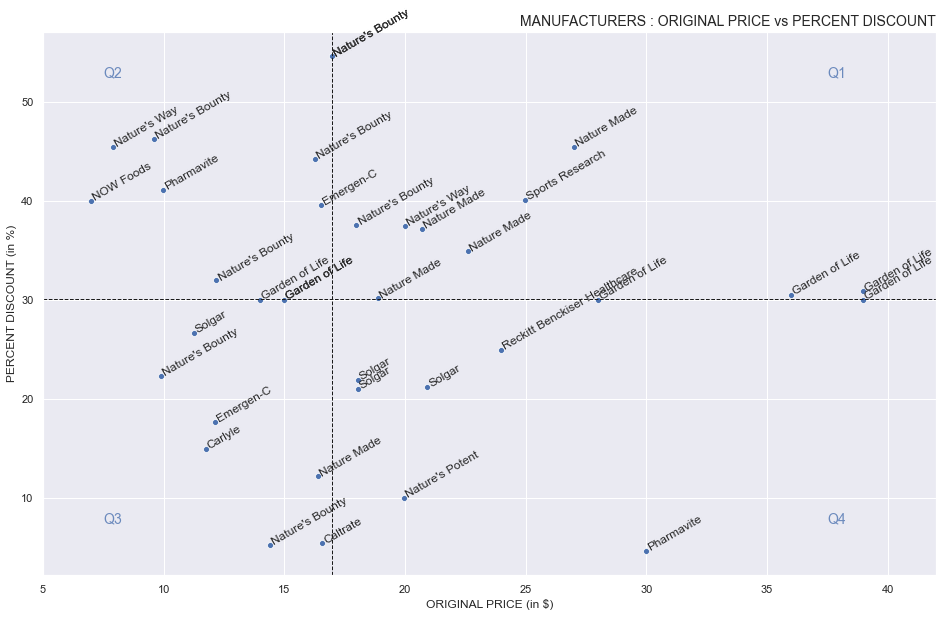

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import markers

sns.set()
plt.figure(figsize=(16,10))

#Scatterplot
sns.scatterplot(data=df_discount, x='ORIGINAL_PRICE', y='PERCENT_DISCOUNT')

# Title 
plt.title(f"MANUFACTURERS : ORIGINAL PRICE vs PERCENT DISCOUNT", loc='right', fontsize=14)

# x and y axis labels
plt.xlabel("ORIGINAL PRICE (in $)")
plt.ylabel("PERCENT DISCOUNT (in %)")

# MANUFACTURER NAMES
for i in range(df_discount.shape[0]):
          plt.text(df_discount.ORIGINAL_PRICE[i], y=df_discount.PERCENT_DISCOUNT[i], 
                   s=df_discount.MANUFACTURER_NAME[i], alpha=1.0, fontsize=12, rotation=30)

#Quadrant Marker          
plt.text(x=7.5, y=7.5, s="Q3",alpha=0.8,fontsize=14, color='b')
plt.text(x=37.5, y=52.5, s="Q1",alpha=0.8,fontsize=14, color='b')
plt.text(x=37.5, y=7.5, s="Q4", alpha=0.8,fontsize=14, color='b')
plt.text(x=7.5, y=52.5, s="Q2", alpha=0.8,fontsize=14, color='b')          

# Benchmark Median values          
plt.axhline(y=df_discount.PERCENT_DISCOUNT.median(), color='k', linestyle='--', linewidth=1)           
plt.axvline(x=df_discount.ORIGINAL_PRICE.median(), color='k',linestyle='--', linewidth=1) 

plt.xlim([5, max(df_discount.ORIGINAL_PRICE)+3])
plt.show()

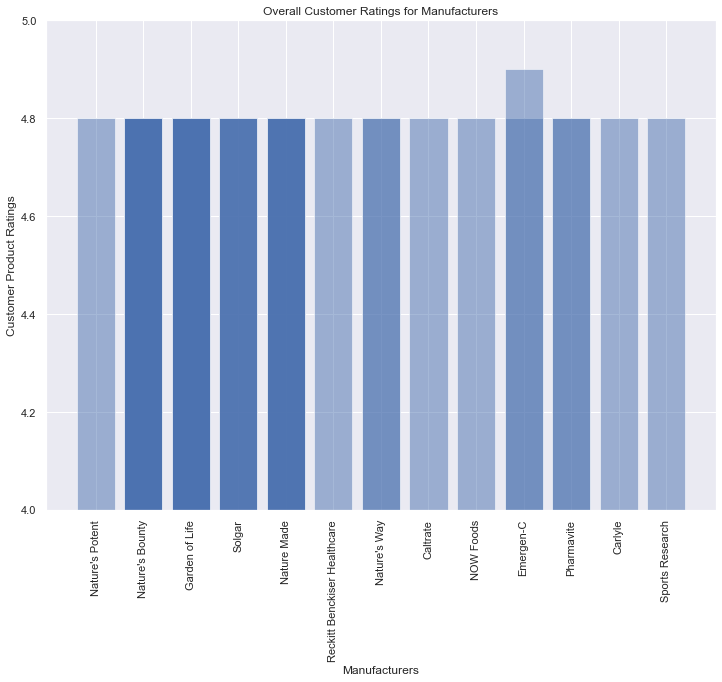

In [5]:
# Bar Graph for Average Customer Ratings for Manufacturers
plt.figure(figsize=(12,9))
plt.bar(df_discount['MANUFACTURER_NAME'],df_discount['CUST_RATINGS'],alpha=0.5)
plt.title('Overall Customer Ratings for Manufacturers')
plt.xlabel('Manufacturers')
plt.xticks(rotation=90)
plt.ylabel('Customer Product Ratings')
plt.ylim(4.0,5.0)
plt.show()

,DISCOUNTED_PRICE,ORIGINAL_PRICE,CUST_RATINGS,TOT_RATINGS,REVIEWS,ANSWERED QS,PERCENT_DISCOUNT
DISCOUNTED_PRICE,1.000000,0.921963,-0.088264,-0.073177,0.233303,0.487453,-0.438898
ORIGINAL_PRICE,0.921963,1.000000,-0.141058,-0.024293,0.281688,0.586070,-0.079244
CUST_RATINGS,-0.088264,-0.141058,1.000000,0.176252,0.312082,0.053168,-0.161294
TOT_RATINGS,-0.073177,-0.024293,0.176252,1.000000,0.784543,0.420839,0.099459
REVIEWS,0.233303,0.281688,0.312082,0.784543,1.000000,0.647319,0.018461
ANSWERED QS,0.487453,0.586070,0.053168,0.420839,0.647319,1.000000,0.047350
PERCENT_DISCOUNT,-0.438898,-0.079244,-0.161294,0.099459,0.018461,0.047350,1.000000


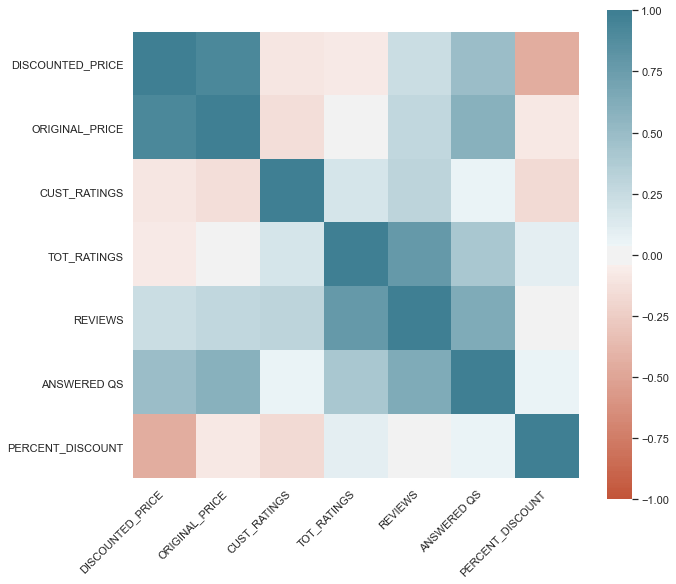

In [6]:
# Compute the correlation among the extracted variables
corr = df_discount.corr()
display(corr)

# Plot the correlation
plt.figure(figsize=(10,9))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Text Analysis for Features of Similar Category Product

In [7]:
# Libraries for Text Analysis
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn import decomposition
from wordcloud import WordCloud 
%matplotlib inline

In [8]:
# Creating a summary stats from the information extracted
try:
    # Connect to server
    conn = mysql.connector.connect(host='localhost',
                                            database=SQL_DB,
                                            user='root',
                                            password='')
    cursor = conn.cursor()
        
    # Fetching the features extracted for all products from database
    features_extract = "SELECT productASIN, categoryName, subCategoryName, productFeatures " \
           "FROM " + SQL_TABLE_DEALS + ";"
    cursor.execute(features_extract)
    results = cursor.fetchall()
    df_features = pd.DataFrame(results)
    column_names = ["ASIN", "CATEGORY", "SUB-CATEGORY", "FEATURE_LIST"]
    df_features.columns = column_names
        
    # Display the results
    print("FEATURE SUMMARY: \n")
    print(df_features.head())
    # Closing the connections
    cursor.close()
    conn.close()

except Exception as ex:
    print("Error:" + str(ex))

FEATURE SUMMARY: 

         ASIN            CATEGORY                    SUB-CATEGORY  \
0  B01FCFOIN2  Health & Household  Vitamins & Dietary Supplements   
1  B00GB85JR4  Health & Household  Vitamins & Dietary Supplements   
2  B000GG87V2  Health & Household  Vitamins & Dietary Supplements   
3  B0098U0QC0  Health & Household  Vitamins & Dietary Supplements   
4  B081SC99FL  Health & Household  Vitamins & Dietary Supplements   

                                        FEATURE_LIST  
0  Immune Support Team - Zinc has immune-enhancin...  
1  most active form: NatureWise Vitamin D3 in cer...  
2  Immune support: 250-count, 500 milligram Vitam...  
3  Zinc with vitamin C: Our Zinc supplement provi...  
4  RICH NATURAL SOURCE OF ZINC - Deep Blue Health...  


In [9]:
# Function to Clean the text data 
def clean_text(string_in):
    # Replace the non-alphabets with spaces
    string_in = re.sub("[^a-zA-Z]", " ", str(string_in))
    # Convert all letters to lower case  
    string_in = string_in.lower()                         
    
    return string_in.strip()

# Function to draw the wordcloud 
def draw_wordcloud(dict, topic_number):
    wc = WordCloud(max_words=1000)    
    wordcloud = WordCloud(colormap="Blues").generate_from_frequencies(dict)
    
    plt.title('Topic %s' %str(topic_number), size = 16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")        
    plt.show()

# Generate the clean text column
df_features["FEATURES_CLEANED"] = df_features.FEATURE_LIST.apply(clean_text)

In [10]:
# Preprocessing the words
preprocessed = [" ".join(RegexpTokenizer(r'\w+').tokenize(df_features.FEATURES_CLEANED[idx])) for idx in df_features.index]

# Storing the stop words for the analysis
custom_stop_words = []
my_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

In [11]:
# Creating the TFIDF for the text data
vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (1,1), 
                             stop_words = my_stop_words)

tfidf = vectorizer.fit_transform(preprocessed)
print("Created document-term matrix of size %d x %d" % (tfidf.shape[0],tfidf.shape[1]))

Created document-term matrix of size 1004 x 4802


In [12]:
# Generating a W(document-topic)) matrix - Limiting to top 3 topics
nmf = decomposition.NMF(init = 'nndsvd', n_components = 3, max_iter = 200)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("Generated W(document-topic)) matrix of size %s and H (topic-word) matrix of size %s" % ( str(W.shape), str(H.shape)))

feature_names = vectorizer.get_feature_names()
n_top_words = 10

# Print top words in each topic
for topic_idx, topic in enumerate(H):
    topic_count = topic_idx + 1
    print("Topic #%d:" % topic_count)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Generated W(document-topic)) matrix of size (1004, 3) and H (topic-word) matrix of size (3, 4802)
Topic #1:
vitamin calcium support immune health bone free healthy iu bones

Topic #2:
zinc immune mg supplement body support skin health supplements healthy

Topic #3:
products provided warm recommendations summer ships stores amazon accordance arrive



In [13]:
# Creating the dataframe for the topics
mydf = pd.DataFrame({"feature_name": feature_names})

for topic_idx, topic in enumerate(H):
    mydf["topic_" + str(topic_idx)] = topic

mylist = list(mydf.itertuples())

features_topic1 = []
features_topic2 = []
features_topic3 = []

for order_id, key, num1, num2, num3 in mylist:
    features_topic1.append((key, num1))
    features_topic2.append((key, num2))
    features_topic3.append((key, num3))

features_topic1 = sorted(features_topic1, key=lambda myword: myword[1], reverse=True)
features_topic2 = sorted(features_topic2, key=lambda myword: myword[1], reverse=True)
features_topic3 = sorted(features_topic3, key=lambda myword: myword[1], reverse=True)

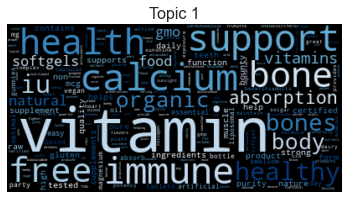

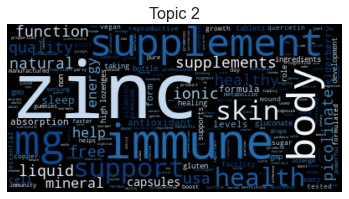

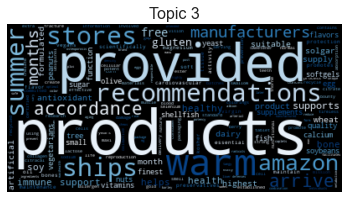

In [14]:
# Display the wordcloud for top 3 topics
draw_wordcloud(dict(features_topic1), topic_number=1)
draw_wordcloud(dict(features_topic2), topic_number=2)
draw_wordcloud(dict(features_topic3), topic_number=3)